In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/BCCC-CIC-IDS-2017

botnet_ares.csv       dos_slowloris.csv		       notebook.ipynb	    web_sql_injection.csv
Combined_2017.csv     friday_benign.csv		       portscan.csv	    web_xss.csv
ddos_loit.csv	      ftp_patator.csv		       ssh_patator-new.csv  wednesday_benign.csv
dos_golden_eye.csv    heartbleed.csv		       thursday_benign.csv
dos_hulk.csv	      monday_benign.csv		       tuesday_benign.csv
dos_slowhttptest.csv  NetFlow-vs-CIC-flows_number.png  web_brute_force.csv


In [3]:

!pip install xgboost==2.1.3
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


## Import Necessary Libraries
In this cell, we import the libraries required for data preprocessing, visualization, model training, and evaluation.
- `pandas` and `numpy` for data manipulation.
- `seaborn` and `matplotlib` for visualization.
- `sklearn` for data splitting and evaluation metrics.
- `xgboost` for training the classification model.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

## Extract the data

In [6]:
# csv_files = glob('/Users/manraj/Downloads/BCCC-CIC-IDS2017/BCCC-CIC-IDS-2017/*.csv')

# df = pd.concat([pd.read_csv(file) for file in csv_files])

# df.to_csv('Combined_2017.csv')

## Load the Dataset
In this cell, we load the dataset into a pandas DataFrame.


In [7]:
df=pd.read_csv("/content/drive/MyDrive/BCCC-CIC-IDS-2017/Combined_2017.csv")

df.drop(['Unnamed: 0'], axis=1, inplace=True)

df = df.apply(
    lambda col: pd.to_numeric(col, downcast="integer") if col.dtypes == "int64" else col
)
df = df.apply(
    lambda col: pd.to_numeric(col, downcast="float") if col.dtypes == "float64" else col
)


In [8]:
df.head()

,flow_id,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,payload_bytes_std,payload_bytes_variance,fwd_payload_bytes_max,fwd_payload_bytes_min,fwd_payload_bytes_mean,fwd_payload_bytes_std,fwd_payload_bytes_variance,bwd_payload_bytes_max,bwd_payload_bytes_min,bwd_payload_bytes_mean,bwd_payload_bytes_std,bwd_payload_bytes_variance,total_header_bytes,max_header_bytes,min_header_bytes,mean_header_bytes,std_header_bytes,fwd_total_header_bytes,fwd_max_header_bytes,fwd_min_header_bytes,fwd_mean_header_bytes,fwd_std_header_bytes,bwd_total_header_bytes,bwd_max_header_bytes,bwd_min_header_bytes,bwd_mean_header_bytes,bwd_std_header_bytes,fwd_avg_segment_size,bwd_avg_segment_size,avg_segment_size,fwd_init_win_bytes,bwd_init_win_bytes,active_min,active_max,active_mean,active_std,idle_min,idle_max,idle_mean,idle_std,bytes_rate,fwd_bytes_rate,bwd_bytes_rate,packets_rate,bwd_packets_rate,fwd_packets_rate,down_up_rate,avg_fwd_bytes_per_bulk,avg_fwd_packets_per_bulk,avg_fwd_bulk_rate,avg_bwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,avg_bwd_bulk_rate,fwd_bulk_state_count,fwd_bulk_total_size,fwd_bulk_per_packet,fwd_bulk_duration,bwd_bulk_state_count,bwd_bulk_total_size,bwd_bulk_per_packet,bwd_bulk_duration,fin_flag_counts,psh_flag_counts,urg_flag_counts,ece_flag_counts,syn_flag_counts,ack_flag_counts,cwr_flag_counts,rst_flag_counts,fwd_fin_flag_counts,fwd_psh_flag_counts,fwd_urg_flag_counts,fwd_ece_flag_counts,fwd_syn_flag_counts,fwd_ack_flag_counts,fwd_cwr_flag_counts,fwd_rst_flag_counts,bwd_fin_flag_counts,bwd_psh_flag_counts,bwd_urg_flag_counts,bwd_ece_flag_counts,bwd_syn_flag_counts,bwd_ack_flag_counts,bwd_cwr_flag_counts,bwd_rst_flag_counts,packets_IAT_mean,packet_IAT_std,packet_IAT_max,packet_IAT_min,packet_IAT_total,fwd_packets_IAT_mean,fwd_packets_IAT_std,fwd_packets_IAT_max,fwd_packets_IAT_min,fwd_packets_IAT_total,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes,label
0,172.16.0.1_60744_192.168.10.50_21_TCP_2017-07-...,2017-07-07 13:14:05.497800,172.16.0.1,60744,192.168.10.50,21,TCP,0.003921,7,4,3,20,0,20,20,0,2.857143,6.998542,48.979592,20,0,2.857143,6.998542,0.0,20,0,2.857143,6.998542,88.888889,240,40,32,34.285713,3.614032,136,40,32,34.0,3.464102,104,40,32,34.666668,3.771236,0.0,6.666667,2.857143,29200,28960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5101.008209,0.0,5101.008209,1785.352873,765.151231,1020.201642,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,2,1,0,0,2,6,0,0,1,0,0,0,1,3,0,0,1,1,0,0,1,3,0,0,0.000653,0.000713,0.002181,0.000066,0.003921,0.001285,0.001061,0.002773,0.000370,0.003855,0.001898,0.000871,0.002769,0.001028,0.003797,0.0,0.0,0.0,0.0,Port_Scan
1,172.16.0.1_45018_192.168.10.50_22_TCP_2017-07-...,2017-07-07 13:14:05.497803,172.16.0.1,45018,192.168.10.50,22,TCP,0.011778,7,4,3,41,0,41,41,0,5.857143,14.347012,205.836735,41,0,5.857143,14.347012,0.0,41,0,5.857143,14.347012,373.555556,240,40,32,34.285713,3.614032,136,40,32,34.0,3.464102,104,40,32,34.666668,3.771236,0.0,13.666667,5.857143,29200,28960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3481.032044,0.0,3481.032044,594.322544,254.709662,339.612882,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,2,1,0,0,2,6,0,0,1,0,0,0,1,3,0,0,1,1,0,0,1,3,0,0,0.001963,0.003147,0.008979,0.000118,0.011778,0.003726,0.004080,0.009493,0.000712,0.011177,0.005830,0.003743,0.009573,0.002087,0.011660,0.0,0.0,0.0,0.0,Port_Scan
2,172.16.0.1_60754_192.168.10.50_21_TCP_2017-07-...,2017-07-07 13:14:17.054064,172.16.0.1,60754,192.168.10.50,21,TCP,0.004274,7,4,3,20,0,20,20,0,2.857143,6.998542,48.979592,20,0,2.857143,6.998542,0.0,20,0,2.857143,6.998542,88.888889,240,40,32,34.285713,3.614032,136,40,32,34.0,3.464102,104,40,32,34.666668,3.771236,0.0,6.666667,2.857143,29200,28960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4679.5

## EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438052 entries, 0 to 2438051
Columns: 122 entries, flow_id to label
dtypes: float32(31), float64(30), int16(10), int32(18), int64(3), int8(24), object(6)
memory usage: 1.3+ GB


- 61 columns with float data type
- 55 columns with int data type
- 6 columns with object data type

In [10]:
df.describe()

,src_port,dst_port,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,payload_bytes_std,payload_bytes_variance,fwd_payload_bytes_max,fwd_payload_bytes_min,fwd_payload_bytes_mean,fwd_payload_bytes_std,fwd_payload_bytes_variance,bwd_payload_bytes_max,bwd_payload_bytes_min,bwd_payload_bytes_mean,bwd_payload_bytes_std,bwd_payload_bytes_variance,total_header_bytes,max_header_bytes,min_header_bytes,mean_header_bytes,std_header_bytes,fwd_total_header_bytes,fwd_max_header_bytes,fwd_min_header_bytes,fwd_mean_header_bytes,fwd_std_header_bytes,bwd_total_header_bytes,bwd_max_header_bytes,bwd_min_header_bytes,bwd_mean_header_bytes,bwd_std_header_bytes,fwd_avg_segment_size,bwd_avg_segment_size,avg_segment_size,fwd_init_win_bytes,bwd_init_win_bytes,active_min,active_max,active_mean,active_std,idle_min,idle_max,idle_mean,idle_std,bytes_rate,fwd_bytes_rate,bwd_bytes_rate,packets_rate,bwd_packets_rate,fwd_packets_rate,down_up_rate,avg_fwd_bytes_per_bulk,avg_fwd_packets_per_bulk,avg_fwd_bulk_rate,avg_bwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,avg_bwd_bulk_rate,fwd_bulk_state_count,fwd_bulk_total_size,fwd_bulk_per_packet,fwd_bulk_duration,bwd_bulk_state_count,bwd_bulk_total_size,bwd_bulk_per_packet,bwd_bulk_duration,fin_flag_counts,psh_flag_counts,urg_flag_counts,ece_flag_counts,syn_flag_counts,ack_flag_counts,cwr_flag_counts,rst_flag_counts,fwd_fin_flag_counts,fwd_psh_flag_counts,fwd_urg_flag_counts,fwd_ece_flag_counts,fwd_syn_flag_counts,fwd_ack_flag_counts,fwd_cwr_flag_counts,fwd_rst_flag_counts,bwd_fin_flag_counts,bwd_psh_flag_counts,bwd_urg_flag_counts,bwd_ece_flag_counts,bwd_syn_flag_counts,bwd_ack_flag_counts,bwd_cwr_flag_counts,bwd_rst_flag_counts,packets_IAT_mean,packet_IAT_std,packet_IAT_max,packet_IAT_min,packet_IAT_total,fwd_packets_IAT_mean,fwd_packets_IAT_std,fwd_packets_IAT_max,fwd_packets_IAT_min,fwd_packets_IAT_total,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes
count,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2438052.0,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2438052.0,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2438052.0,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06,2.438052e+06
mean,4.281378e+04,6.436933e+03,1.597984e+01,2.136122e+01,9.881991e+00,1.147923e+01,1.852672e+04,4.711991e+02,1.805552e+04,1.050917e+03,1.482433e+01,1.841033e+02,3.092358e+02,4.832976e+05,1.050917e+03,1.482433e+01,1.841033e+02,3.092358e+02,2.751124e+04,1.050917e+03,1.482433e+01,1.841033e+02,3.092358e+02,7.963305e+05,4.850038e+02,2.31807

We see that there are negative values for some columns further analysis down below.

In [11]:
# Categorization of Features in the Dataset

ip_protocol_features = [
    "flow_id", "src_ip", "src_port", "dst_ip", "dst_port", "protocol", "timestamp"
]


traffic_features = [
    "packets_count", "fwd_packets_count", "bwd_packets_count",
    "total_payload_bytes", "fwd_total_payload_bytes", "bwd_total_payload_bytes",
    "bytes_rate", "fwd_bytes_rate", "bwd_bytes_rate", "packets_rate",
    "fwd_packets_rate", "bwd_packets_rate", "down_up_rate"
]

tcp_features = [
    "fin_flag_counts", "psh_flag_counts", "urg_flag_counts", "ece_flag_counts",
    "syn_flag_counts", "ack_flag_counts", "cwr_flag_counts", "rst_flag_counts",
    "fwd_fin_flag_counts", "fwd_psh_flag_counts", "fwd_urg_flag_counts",
    "fwd_ece_flag_counts", "fwd_syn_flag_counts", "fwd_ack_flag_counts",
    "fwd_cwr_flag_counts", "fwd_rst_flag_counts", "bwd_fin_flag_counts",
    "bwd_psh_flag_counts", "bwd_urg_flag_counts", "bwd_ece_flag_counts",
    "bwd_syn_flag_counts", "bwd_ack_flag_counts", "bwd_cwr_flag_counts",
    "bwd_rst_flag_counts", "fwd_init_win_bytes", "bwd_init_win_bytes"
]


packet_flow_features = [
    "payload_bytes_max", "payload_bytes_min", "payload_bytes_mean",
    "payload_bytes_std", "payload_bytes_variance", "fwd_payload_bytes_max",
    "fwd_payload_bytes_min", "fwd_payload_bytes_mean", "fwd_payload_bytes_std",
    "fwd_payload_bytes_variance", "bwd_payload_bytes_max", "bwd_payload_bytes_min",
    "bwd_payload_bytes_mean", "bwd_payload_bytes_std", "bwd_payload_bytes_variance",
    "total_header_bytes", "max_header_bytes", "min_header_bytes",
    "mean_header_bytes", "std_header_bytes", "fwd_total_header_bytes",
    "fwd_max_header_bytes", "fwd_min_header_bytes", "fwd_mean_header_bytes",
    "fwd_std_header_bytes", "bwd_total_header_bytes", "bwd_max_header_bytes",
    "bwd_min_header_bytes", "bwd_mean_header_bytes", "bwd_std_header_bytes",
    "fwd_avg_segment_size", "bwd_avg_segment_size", "avg_segment_size"
]

timing_features = [
    "active_min", "active_max", "active_mean", "active_std",
    "idle_min", "idle_max", "idle_mean", "idle_std",
    "packets_IAT_mean", "packet_IAT_std", "packet_IAT_max", "packet_IAT_min",
    "packet_IAT_total", "fwd_packets_IAT_mean", "fwd_packets_IAT_std",
    "fwd_packets_IAT_max", "fwd_packets_IAT_min", "fwd_packets_IAT_total",
    "bwd_packets_IAT_mean", "bwd_packets_IAT_std", "bwd_packets_IAT_max",
    "bwd_packets_IAT_min", "bwd_packets_IAT_total"
]

bulk_rate_features = [
    "avg_fwd_bytes_per_bulk", "avg_fwd_packets_per_bulk", "avg_fwd_bulk_rate",
    "avg_bwd_bytes_per_bulk", "avg_bwd_packets_bulk_rate", "avg_bwd_bulk_rate",
    "fwd_bulk_state_count", "fwd_bulk_total_size", "fwd_bulk_per_packet",
    "fwd_bulk_duration", "bwd_bulk_state_count", "bwd_bulk_total_size",
    "bwd_bulk_per_packet", "bwd_bulk_duration"
]

subflow_features = [
    "subflow_fwd_packets", "subflow_bwd_packets", "subflow_fwd_bytes", "subflow_bwd_bytes"
]

target_features = ["label"]

feature_categories = {
    "IP and Protocol Information": ip_protocol_features,
    "Traffic Volume and Packet Information": traffic_features,
    "TCP Flags and Window Size": tcp_features,
    "Packet Size and Flow Characteristics": packet_flow_features,
    "Timing and Activity Information": timing_features,
    "Custom Bulk and Rate Features": bulk_rate_features,
    "Subflow Features": subflow_features,
    "Target/Label": target_features
}

count=1
for category, features in feature_categories.items():
    count+=len(features)
    # print(f"{category}:\n{features}\n")

For my reference I put columns in categroies:

1. IP and Protocol Information:

  - Represents data related to IP addresses and network protocols.

2. Traffic Volume and Packet Information:

  - Includes features that describe the volume of traffic and number of packets exchanged during communication.

3. TCP Flags and Window Size:

  - Contains details about TCP protocol flags and window size used in data transmission.

4. Packet Size and Flow Characteristics:

  - Describes the size and behavior of packets in the data flow.

5. Timing and Activity Information:

  - Captures timing-related metrics and activity patterns during communication.

6. Custom Bulk and Rate Features:

  - Features that represent bulk data rates or similar metrics.

7. Subflow Features:

  - Provides information about subflows within the main data flow.

8. Target/Label:

  - The target feature(s) used for supervised learning tasks.


| **Feature**                 | **Data Type** | **Description**                                                                 |
|-----------------------------|---------------|---------------------------------------------------------------------------------|
| `flow_id`                   | object        | Unique identifier for each network flow.                                       |
| `timestamp`                 | object        | Timestamp when the network flow was recorded.                                  |
| `src_ip`                    | object        | Source IP address initiating the network flow.                                 |
| `src_port`                  | int64         | Source port number used in the flow.                                           |
| `dst_ip`                    | object        | Destination IP address receiving the network flow.                             |
| `dst_port`                  | int64         | Destination port number used in the flow.                                      |
| `protocol`                  | object        | Protocol used in the network flow (e.g., TCP, UDP).                            |
| `duration`                  | float64       | Duration of the flow in seconds.                                               |
| `packets_count`             | int64         | Total number of packets exchanged in the flow.                                 |
| `fwd_packets_count`         | int64         | Number of packets sent in the forward direction.                               |
| `bwd_packets_count`         | int64         | Number of packets sent in the backward direction.                              |
| `total_payload_bytes`       | int64         | Total number of payload bytes exchanged in the flow.                           |
| `fwd_total_payload_bytes`   | int64         | Total payload bytes sent in the forward direction.                             |
| `bwd_total_payload_bytes`   | int64         | Total payload bytes sent in the backward direction.                            |
| `payload_bytes_max`         | int64         | Maximum size of payload bytes in a packet.                                     |
| `payload_bytes_min`         | int64         | Minimum size of payload bytes in a packet.                                     |
| `payload_bytes_mean`        | float64       | Mean size of payload bytes in packets.                                         |
| `payload_bytes_std`         | float64       | Standard deviation of payload byte sizes in packets.                           |
| `payload_bytes_variance`    | float64       | Variance in payload byte sizes in packets.                                     |
| `fwd_payload_bytes_max`     | int64         | Maximum size of payload bytes in the forward direction.                        |
| `fwd_payload_bytes_min`     | int64         | Minimum size of payload bytes in the forward direction.                        |
| `fwd_payload_bytes_mean`    | float64       | Mean size of payload bytes in the forward direction.                           |
| `fwd_payload_bytes_std`     | float64       | Standard deviation of payload byte sizes in the forward direction.             |
| `fwd_payload_bytes_variance`| float64       | Variance in payload byte sizes in the forward direction.                       |
| `bwd_payload_bytes_max`     | int64         | Maximum size of payload bytes in the backward direction.                       |
| `bwd_payload_bytes_min`     | int64         | Minimum size of payload bytes in the backward direction.                       |
| `bwd_payload_bytes_mean`    | float64       | Mean size of payload bytes in the backward direction.                          |
| `bwd_payload_bytes_std`     | float64       | Standard deviation of payload byte sizes in the backward direction.            |
| `bwd_payload_bytes_variance`| float64       | Variance in payload byte sizes in the backward direction.                      |
| `total_header_bytes`        | int64         | Total size of header bytes in the flow.                                        |
| `max_header_bytes`          | int64         | Maximum size of header bytes in a packet.                                      |
| `min_header_bytes`          | int64         | Minimum size of header bytes in a packet.                                      |
| `mean_header_bytes`         | float64       | Mean size of header bytes in packets.                                          |
| `std_header_bytes`          | float64       | Standard deviation of header byte sizes in packets.                            |
| `fwd_total_header_bytes`    | int64         | Total size of header bytes in the forward direction.                           |
| `fwd_max_header_bytes`      | int64         | Maximum size of header bytes in the forward direction.                         |
| `fwd_min_header_bytes`      | int64         | Minimum size of header bytes in the forward direction.                         |
| `fwd_mean_header_bytes`     | float64       | Mean size of header bytes in the forward direction.                            |
| `fwd_std_header_bytes`      | float64       | Standard deviation of header byte sizes in the forward direction.              |
| `bwd_total_header_bytes`    | int64         | Total size of header bytes in the backward direction.                          |
| `bwd_max_header_bytes`      | int64         | Maximum size of header bytes in the backward direction.                        |
| `bwd_min_header_bytes`      | int64         | Minimum size of header bytes in the backward direction.                        |
| `bwd_mean_header_bytes`     | float64       | Mean size of header bytes in the backward direction.                           |
| `bwd_std_header_bytes`      | float64       | Standard deviation of header byte sizes in the backward direction.             |
| `fwd_avg_segment_size`      | float64       | Average size of TCP segments in the forward direction.                         |
| `bwd_avg_segment_size`      | float64       | Average size of TCP segments in the backward direction.                        |
| `avg_segment_size`          | float64       | Average size of TCP segments in both directions.                               |
| `fwd_init_win_bytes`        | int64         | Initial window size for the forward direction.                                 |
| `bwd_init_win_bytes`        | int64         | Initial window size for the backward direction.                                |
| `active_min`                | float64       | Minimum active time between packets in the flow.                               |
| `active_max`                | float64       | Maximum active time between packets in the flow.                               |
| `active_mean`               | float64       | Mean active time between packets in the flow.                                  |
| `active_std`                | float64       | Standard deviation of active time between packets in the flow.                 |
| `idle_min`                  | float64       | Minimum idle time between packets in the flow.                                 |
| `idle_max`                  | float64       | Maximum idle time between packets in the flow.                                 |
| `idle_mean`                 | float64       | Mean idle time between packets in the flow.                                    |
| `idle_std`                  | float64       | Standard deviation of idle time between packets in the flow.                   |
| `bytes_rate`                | float64       | Rate of bytes exchanged per second.                                            |
| `fwd_bytes_rate`            | float64       | Rate of bytes sent in the forward direction per second.                        |
| `bwd_bytes_rate`            | float64       | Rate of bytes sent in the backward direction per second.                       |
| `packets_rate`              | float64       | Rate of packets exchanged per second.                                          |
| `bwd_packets_rate`          | float64       | Rate of packets sent in the backward direction per second.                     |
| `fwd_packets_rate`          | float64       | Rate of packets sent in the forward direction per second.                      |
| `down_up_rate`              | float64       | Ratio of downstream to upstream data rates.                                    |
| `avg_fwd_bytes_per_bulk`    | float64       | Average forward bytes per bulk transfer.                                       |
| `avg_fwd_packets_per_bulk`  | float64       | Average forward packets per bulk transfer.                                     |
| `avg_fwd_bulk_rate`         | float64       | Average rate of forward bulk transfers.                                        |
| `avg_bwd_bytes_per_bulk`    | float64       | Average backward bytes per bulk transfer.                                      |
| `avg_bwd_packets_bulk_rate` | float64       | Average backward packets per bulk transfer.                                    |
| `avg_bwd_bulk_rate`         | float64       | Average rate of backward bulk transfers.                                       |
| `fwd_bulk_state_count`      | int64         | Number of forward bulk states.                                                 |
| `fwd_bulk_total_size`       | int64         | Total size of forward bulk transfers.                                          |
| `fwd_bulk_per_packet`       | int64         | Average size of forward bulk transfers per packet.                             |
| `fwd_bulk_duration`         | float64       | Duration of forward bulk transfers.                                            |
| `bwd_bulk_state_count`      | int64         | Number of backward bulk states.                                                |
| `bwd_bulk_total_size`       | int64         | Total size of backward bulk transfers.                                         |
| `bwd_bulk_per_packet`       | int64         | Average size of backward bulk transfers per packet.                            |
| `bwd_bulk_duration`         | float64       | Duration of backward bulk transfers.                                           |
| `fin_flag_counts`           | int64         | Number of FIN flags set in TCP packets.                                        |
| `psh_flag_counts`           | int64         | Number of PSH flags set in TCP packets.                                        |
| `urg_flag_counts`           | int64         | Number of URG flags set in TCP packets.                                        |
| `ece_flag_counts`           | int64         | Number of ECE flags set in TCP packets.                                        |
| `syn_flag_counts`           | int64         | Number of SYN flags set in TCP packets.                                        |
| `ack_flag_counts`           | int64         | Number of ACK flags set in TCP packets.                                        |
| `cwr_flag_counts`           | int64         | Number of CWR flags set in TCP packets.                                        |
| `rst_flag_counts`           | int64         | Number of RST flags set in TCP packets.                                        |
| `fwd_fin_flag_counts`       | int64         | Number of FIN flags in forward TCP packets.                                    |
| `fwd_psh_flag_counts`       | int64         | Number of PSH flags in forward TCP packets.                                    |
| `fwd_urg_flag_counts`       | int64         | Number of URG flags in forward TCP packets.                                    |
| `fwd_ece_flag_counts`       | int64         | Number of ECE flags in forward TCP packets.                                    |
| `fwd_syn_flag_counts`       | int64         | Number of SYN flags in forward TCP packets.                                    |
| `fwd_ack_flag_counts`       | int64         | Number of ACK flags in forward TCP packets.                                    |
| `fwd_cwr_flag_counts`       | int64         | Number of CWR flags in forward TCP packets.                                    |
| `fwd_rst_flag_counts`       | int64         | Number of RST flags in forward TCP packets.                                    |
| `bwd_fin_flag_counts`       | int64         | Number of FIN flags in backward TCP packets.                                   |
| `bwd_psh_flag_counts`       | int64         | Number of PSH flags in backward TCP packets.                                   |
| `bwd_urg_flag_counts`       | int64         | Number of URG flags in backward TCP packets.                                   |
| `bwd_ece_flag_counts`       | int64         | Number of ECE flags in backward TCP packets.                                   |
| `bwd_syn_flag_counts`       | int64         | Number of SYN flags in backward TCP packets.                                   |
| `bwd_ack_flag_counts`       | int64         | Number of ACK flags in backward TCP packets.                                   |
| `bwd_cwr_flag_counts`       | int64         | Number of CWR flags in backward TCP packets.                                   |
| `bwd_rst_flag_counts`       | int64         | Number of RST flags in backward TCP packets.                                   |
| `packets_IAT_mean`          | float64       | Mean inter-arrival time (IAT) between packets.                                 |
| `packets_IAT_std`           | float64       | Standard deviation of inter-arrival time (IAT) between packets.                |
| `packets_IAT_max`           | float64       | Maximum inter-arrival time (IAT) between packets.                              |
| `packets_IAT_min`           | float64       | Minimum inter-arrival time (IAT) between packets.                              |
| `packets_IAT_total`         | float64       | Total inter-arrival time (IAT) between packets.                                |
| `fwd_packets_IAT_mean`      | float64       | Mean inter-arrival time (IAT) of forward packets.                              |
| `fwd_packets_IAT_std`       | float64       | Standard deviation of inter-arrival time (IAT) of forward packets.             |
| `fwd_packets_IAT_max`       | float64       | Maximum inter-arrival time (IAT) of forward packets.                           |
| `fwd_packets_IAT_min`       | float64       | Minimum inter-arrival time (IAT) of forward packets.                           |
| `fwd_packets_IAT_total`     | float64       | Total inter-arrival time (IAT) of forward packets.                             |
| `bwd_packets_IAT_mean`      | float64       | Mean inter-arrival time (IAT) of backward packets.                             |
| `bwd_packets_IAT_std`       | float64       | Standard deviation of inter-arrival time (IAT) of backward packets.            |
| `bwd_packets_IAT_max`       | float64       | Maximum inter-arrival time (IAT) of backward packets.                          |
| `bwd_packets_IAT_min`       | float64       | Minimum inter-arrival time (IAT) of backward packets.                          |
| `bwd_packets_IAT_total`     | float64       | Total inter-arrival time (IAT) of backward packets.                            |
| `subflow_fwd_packets`       | float64       | Number of packets in the forward subflow.                                      |
| `subflow_bwd_packets`       | float64       | Number of packets in the backward subflow.                                     |
| `subflow_fwd_bytes`         | float64       | Total bytes in the forward subflow.                                            |
| `subflow_bwd_bytes`         | float64       | Total bytes in the backward subflow.                                           |
| `label`                     | object        | Target variable indicating the class or label of the flow.                     |


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438052 entries, 0 to 2438051
Columns: 122 entries, flow_id to label
dtypes: float32(31), float64(30), int16(10), int32(18), int64(3), int8(24), object(6)
memory usage: 1.3+ GB


In [13]:
num_cols = df.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns
cat_cols = df.select_dtypes(include=['object']).columns

print(f"There are {len(num_cols)} numerical columns.")
print(f"There are {len(cat_cols)} categorical columns.")

There are 116 numerical columns.
There are 6 categorical columns.


Checking for missing rows percentage.

None missing.

In [14]:
print(df.isna().mean())

flow_id                       0.0
timestamp                     0.0
src_ip                        0.0
src_port                      0.0
dst_ip                        0.0
dst_port                      0.0
protocol                      0.0
duration                      0.0
packets_count                 0.0
fwd_packets_count             0.0
bwd_packets_count             0.0
total_payload_bytes           0.0
fwd_total_payload_bytes       0.0
bwd_total_payload_bytes       0.0
payload_bytes_max             0.0
payload_bytes_min             0.0
payload_bytes_mean            0.0
payload_bytes_std             0.0
payload_bytes_variance        0.0
fwd_payload_bytes_max         0.0
fwd_payload_bytes_min         0.0
fwd_payload_bytes_mean        0.0
fwd_payload_bytes_std         0.0
fwd_payload_bytes_variance    0.0
bwd_payload_bytes_max         0.0
bwd_payload_bytes_min         0.0
bwd_payload_bytes_mean        0.0
bwd_payload_bytes_std         0.0
bwd_payload_bytes_variance    0.0
total_header_b

I selected three specific attacks for analysis due to their larger representation in the dataset, ensuring a more comprehensive evaluation.

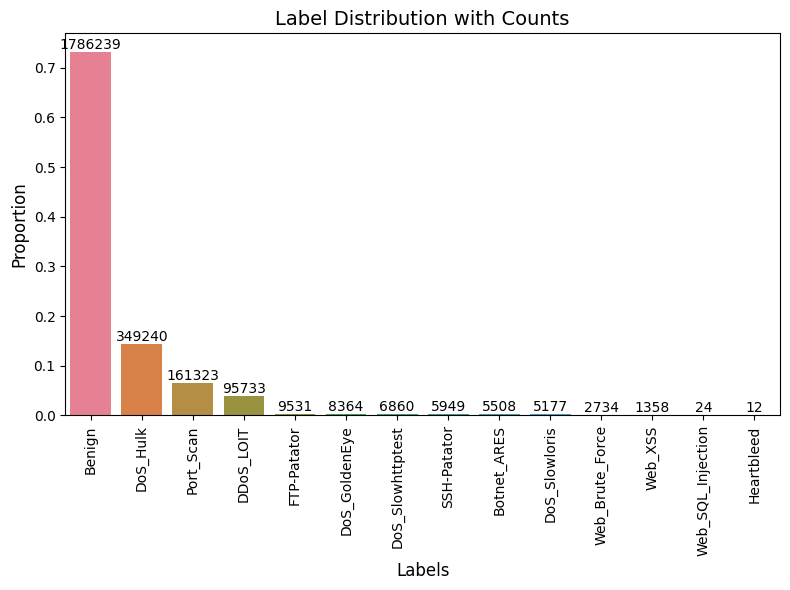

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(x=df['label'].value_counts().index,
            y=df['label'].value_counts().values / len(df),
            ax=ax,
            hue=df['label'].value_counts().index)

for index, value in enumerate(df['label'].value_counts().values):
    percentage = value / len(df)
    ax.text(index, percentage, f'{value}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Labels', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
plt.xticks(rotation=90)
plt.title('Label Distribution with Counts', fontsize=14)
plt.tight_layout()

plt.show()


Created a new binary feature target to act as an indicator of benign (0) or malicious (1) behavior.









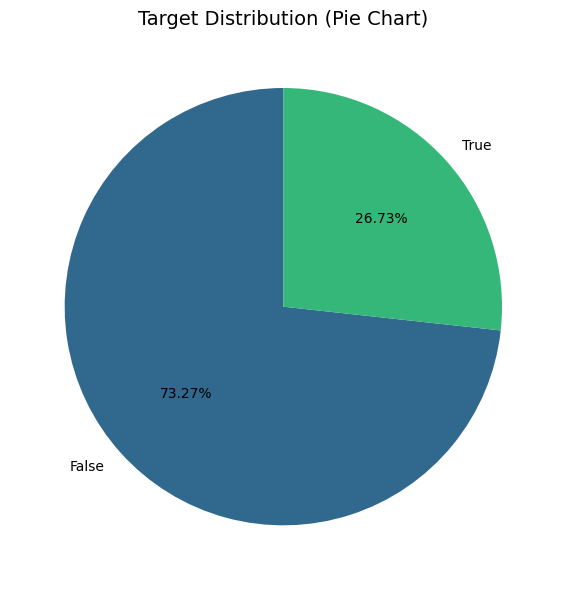

In [16]:
df['target'] = np.where(df['label'] == 'Benign', False, True)

values = df['target'].value_counts().values
labels = ['False', 'True']  # Adjust labels to match your data

plt.figure(figsize=(8, 6))
plt.pie(
    values,
    labels=labels,
    autopct='%1.2f%%',  # Show percentages on the chart
    startangle=90,
    colors=sns.color_palette('viridis', len(values))
)

plt.title('Target Distribution (Pie Chart)', fontsize=14)
plt.tight_layout()
plt.show()

# Handle Negative Values
In this cell, we identify and remove rows with invalid negative values.
- Some numeric columns may have invalid negative values (e.g., `duration` cannot be negative).
- Valid negative columns are specified (e.g., `active_min`, `active_max`, `active_mean`), which are could be preserved if we want.


In [17]:
numeric_df = df.select_dtypes(include=['number'])

# Filter rows where any numeric column has a negative value
rows_with_negative_values = df[(numeric_df < 0).any(axis=1)]

print(f"Number of rows with negative values: {len(rows_with_negative_values)}")
display(rows_with_negative_values.head())

Number of rows with negative values: 53321


,flow_id,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,payload_bytes_std,payload_bytes_variance,fwd_payload_bytes_max,fwd_payload_bytes_min,fwd_payload_bytes_mean,fwd_payload_bytes_std,fwd_payload_bytes_variance,bwd_payload_bytes_max,bwd_payload_bytes_min,bwd_payload_bytes_mean,bwd_payload_bytes_std,bwd_payload_bytes_variance,total_header_bytes,max_header_bytes,min_header_bytes,mean_header_bytes,std_header_bytes,fwd_total_header_bytes,fwd_max_header_bytes,fwd_min_header_bytes,fwd_mean_header_bytes,fwd_std_header_bytes,bwd_total_header_bytes,bwd_max_header_bytes,bwd_min_header_bytes,bwd_mean_header_bytes,bwd_std_header_bytes,fwd_avg_segment_size,bwd_avg_segment_size,avg_segment_size,fwd_init_win_bytes,bwd_init_win_bytes,active_min,active_max,active_mean,active_std,idle_min,idle_max,idle_mean,idle_std,bytes_rate,fwd_bytes_rate,bwd_bytes_rate,packets_rate,bwd_packets_rate,fwd_packets_rate,down_up_rate,avg_fwd_bytes_per_bulk,avg_fwd_packets_per_bulk,avg_fwd_bulk_rate,avg_bwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,avg_bwd_bulk_rate,fwd_bulk_state_count,fwd_bulk_total_size,fwd_bulk_per_packet,fwd_bulk_duration,bwd_bulk_state_count,bwd_bulk_total_size,bwd_bulk_per_packet,bwd_bulk_duration,fin_flag_counts,psh_flag_counts,urg_flag_counts,ece_flag_counts,syn_flag_counts,ack_flag_counts,cwr_flag_counts,rst_flag_counts,fwd_fin_flag_counts,fwd_psh_flag_counts,fwd_urg_flag_counts,fwd_ece_flag_counts,fwd_syn_flag_counts,fwd_ack_flag_counts,fwd_cwr_flag_counts,fwd_rst_flag_counts,bwd_fin_flag_counts,bwd_psh_flag_counts,bwd_urg_flag_counts,bwd_ece_flag_counts,bwd_syn_flag_counts,bwd_ack_flag_counts,bwd_cwr_flag_counts,bwd_rst_flag_counts,packets_IAT_mean,packet_IAT_std,packet_IAT_max,packet_IAT_min,packet_IAT_total,fwd_packets_IAT_mean,fwd_packets_IAT_std,fwd_packets_IAT_max,fwd_packets_IAT_min,fwd_packets_IAT_total,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes,label,target
163037,172.16.0.1_49756_192.168.10.50_22_TCP_2017-07-...,2017-07-04 13:44:41.138954,172.16.0.1,49756,192.168.10.50,22,TCP,11.501601,55,22,33,4753,2008,2745,976,0,86.418182,186.482437,34775.697851,976,0,86.418182,186.482437,18226.380165,976,0,86.418182,186.482437,45782.391185,1776,40,32,32.290909,1.497546,712,40,32,32.363636,1.666391,1064,40,32,32.242424,1.371359,91.272728,83.181816,86.418182,29200,28960,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,413.246817,174.584391,238.662427,4.781943,2.869166,1.912777,1.500000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,2,31,0,0,2,54,0,0,1,16,0,0,1,21,0,0,1,15,0,0,1,33,0,0,0.212993,0.575535,2.059942,-0.000001,11.501601,0.547695,0.850846,2.114005,0.000221,11.501601,0.359363,0.711754,2.059942,0.000003,11.499613,3.666667,5.500000,334.666667,334.666667,SSH-Patator,True
163681,172.16.0.1_51056_192.168.10.50_22_TCP_2017-07-...,2017-07-04 13:57:51.986522,172.16.0.1,51056,192.168.10.50,22,TCP,11.323594,53,22,31,4753,2008,2745,976,0,89.679245,189.197083,35795.538626,976,0,89.679245,189.197083,18226.380165,976,0,89.679245,189.197083,48260.892820,1712,40,32,32.301888,1.524454,712,40,32,32.363636,1.666391,1000,40,32,32.258064,1.413478,91.272728,88.548386,89.679245,29200,28960,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,419.743057,177.328857,242.414200,4.680493,2.737647,1.942846,1.409091,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,2,31,0,0,2,52,0,0,1,16,0,0,1,21,0,0,1,15,0,0,1,31,0,0,0.217761,0.583695,2.336189,-0.000001,11.323594,0.539219,0.861245,2.398100,0.000243,11.323594,0.376854,0.728656,2.336189,0.000041,11.305611,3.666667,5.166667,334.666667,334.666667,SSH-Patator,True
167086,172.16.0.1_52032_192.168.10.50_22_TCP_2017-07-...,2017-07-04 14:07:01.839467,172.16.0.1,52032,192.168.10.50,22,TCP,12

In [18]:
total_counts = df['label'].value_counts()

negative_counts = df['label'].loc[df['active_mean'] < 0].value_counts()

percentages = (negative_counts / total_counts * 100).sort_values(ascending=False)

result = pd.DataFrame({
    'Count': negative_counts,
    'Total': total_counts,
    'Percentage': percentages
}).dropna()

print(result)

                    Count    Total  Percentage
label                                         
Benign            49062.0  1786239    2.746665
DoS_GoldenEye       660.0     8364    7.890961
DoS_Hulk             24.0   349240    0.006872
DoS_Slowhttptest    987.0     6860   14.387755
DoS_Slowloris       256.0     5177    4.944949
FTP-Patator          11.0     9531    0.115413
SSH-Patator          10.0     5949    0.168095


In [19]:
total_counts = df['label'].value_counts()

negative_counts = df['label'].loc[df['packet_IAT_min'] < 0].value_counts()

percentages = (negative_counts / total_counts * 100).sort_values(ascending=False)

result = pd.DataFrame({
    'Count': negative_counts,
    'Total': total_counts,
    'Percentage': percentages
}).dropna()

print(result)

                   Count    Total  Percentage
label                                        
Benign            2104.0  1786239    0.117789
DDoS_LOIT           46.0    95733    0.048050
DoS_GoldenEye        6.0     8364    0.071736
DoS_Hulk           182.0   349240    0.052113
DoS_Slowhttptest     1.0     6860    0.014577
FTP-Patator          4.0     9531    0.041968
Heartbleed           1.0       12    8.333333
SSH-Patator          2.0     5949    0.033619


| **Column**                                | **What It Represents**                                                                                   | **Negative Values Valid?**  | **Reason**                                                                                       |
|-------------------------------------------|-----------------------------------------------------------------------------------------------------------|------------------------------|--------------------------------------------------------------------------------------------------|
| **`duration`**                            | Total duration of the flow or connection (in seconds or milliseconds).                                    | No                           | Duration represents a time interval and cannot logically be negative.                           |
| **`active_min`, `active_max`, `active_mean`** | Metrics for the active time (time during which a connection remains active).                              | Depends                      | Negative values might occur due to timestamp synchronization errors or specific dataset logic.  |
| **`packets_rate`**                        | The rate at which packets are sent during the flow (packets/second).                                      | No                           | Rates cannot logically be negative, as they represent quantities over time.                     |
| **`bwd_packets_rate`**                    | The rate at which backward packets are sent during the flow (packets/second).                             | Depends                      | If the dataset uses specific directional offsets or corrections, negatives might be valid.      |
| **`packets_IAT_mean`, `packet_IAT_max`, `packet_IAT_min`, `packet_IAT_total`** | Inter-arrival times (IAT) between packets in the flow (time gaps between packets).                        | No                           | Time intervals should always be non-negative unless errors occurred during data collection.     |
| **`bwd_packets_IAT_mean`, `bwd_packets_IAT_max`, `bwd_packets_IAT_min`, `bwd_packets_IAT_total`** | Inter-arrival times (IAT) specifically for backward packets in the flow.                                  | Depends                      | Usually invalid, but may be valid if backward flows have specific offset definitions in the dataset. |


For now only considering the non negative values.

In [20]:
df = df[(numeric_df >= 0).all(axis=1)].reset_index(drop=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2384731 entries, 0 to 2384730
Columns: 123 entries, flow_id to target
dtypes: bool(1), float32(31), float64(30), int16(10), int32(18), int64(3), int8(24), object(6)
memory usage: 1.2+ GB


## Remove Duplicates
In this cell, we remove duplicate rows from the dataset to avoid redundancy during model training.
- This step ensures data integrity and prevents overfitting due to repeated information.



According to the [document](https://hal.science/hal-03775466v1/document), the Flow ID should be unique. This is why we focus on identifying duplicates based on the Flow ID rather than considering the entire rows for duplication.









In [22]:
duplicates = df[df['flow_id'].duplicated(keep=False)]

num_duplicates = df[df['flow_id'].duplicated(keep=False)].shape[0]
print(f"Number of duplicate rows based on 'flow_id': {num_duplicates}")

if num_duplicates > 0:
    print("Actual duplicate rows based on 'flow_id':")
    display(duplicates.head(5))

    df = df.drop_duplicates(subset=['flow_id'], keep='first')

else:
    print("No duplicate rows found based on 'flow_id'.")


Number of duplicate rows based on 'flow_id': 6366
Actual duplicate rows based on 'flow_id':


,flow_id,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,payload_bytes_std,payload_bytes_variance,fwd_payload_bytes_max,fwd_payload_bytes_min,fwd_payload_bytes_mean,fwd_payload_bytes_std,fwd_payload_bytes_variance,bwd_payload_bytes_max,bwd_payload_bytes_min,bwd_payload_bytes_mean,bwd_payload_bytes_std,bwd_payload_bytes_variance,total_header_bytes,max_header_bytes,min_header_bytes,mean_header_bytes,std_header_bytes,fwd_total_header_bytes,fwd_max_header_bytes,fwd_min_header_bytes,fwd_mean_header_bytes,fwd_std_header_bytes,bwd_total_header_bytes,bwd_max_header_bytes,bwd_min_header_bytes,bwd_mean_header_bytes,bwd_std_header_bytes,fwd_avg_segment_size,bwd_avg_segment_size,avg_segment_size,fwd_init_win_bytes,bwd_init_win_bytes,active_min,active_max,active_mean,active_std,idle_min,idle_max,idle_mean,idle_std,bytes_rate,fwd_bytes_rate,bwd_bytes_rate,packets_rate,bwd_packets_rate,fwd_packets_rate,down_up_rate,avg_fwd_bytes_per_bulk,avg_fwd_packets_per_bulk,avg_fwd_bulk_rate,avg_bwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,avg_bwd_bulk_rate,fwd_bulk_state_count,fwd_bulk_total_size,fwd_bulk_per_packet,fwd_bulk_duration,bwd_bulk_state_count,bwd_bulk_total_size,bwd_bulk_per_packet,bwd_bulk_duration,fin_flag_counts,psh_flag_counts,urg_flag_counts,ece_flag_counts,syn_flag_counts,ack_flag_counts,cwr_flag_counts,rst_flag_counts,fwd_fin_flag_counts,fwd_psh_flag_counts,fwd_urg_flag_counts,fwd_ece_flag_counts,fwd_syn_flag_counts,fwd_ack_flag_counts,fwd_cwr_flag_counts,fwd_rst_flag_counts,bwd_fin_flag_counts,bwd_psh_flag_counts,bwd_urg_flag_counts,bwd_ece_flag_counts,bwd_syn_flag_counts,bwd_ack_flag_counts,bwd_cwr_flag_counts,bwd_rst_flag_counts,packets_IAT_mean,packet_IAT_std,packet_IAT_max,packet_IAT_min,packet_IAT_total,fwd_packets_IAT_mean,fwd_packets_IAT_std,fwd_packets_IAT_max,fwd_packets_IAT_min,fwd_packets_IAT_total,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes,label,target
174035,192.168.10.51_48915_157.240.2.25_443_TCP_2017-...,2017-07-04 08:35:08.835483,192.168.10.51,48915,157.240.2.25,443,TCP,0.0,1,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,20,20,20,20.0,0.0,20,20,20,20.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.499172e+09,0.0,1.499172e+09,1.499172e+09,1.499172e+09,1.499172e+09,0.0,1.499172e+09,1.499172e+09,1.499172e+09,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,Benign,False
174051,192.168.10.51_48915_157.240.2.25_443_TCP_2017-...,2017-07-04 08:35:08.835483,192.168.10.51,48915,157.240.2.25,443,TCP,0.0,1,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,20,20,20,20.0,0.0,20,20,20,20.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.499172e+09,0.0,1.499172e+09,1.499172e+09,1.499172e+09,1.499172e+09,0.0,1.499172e+09,1.499172e+09,1.499172e+09,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,Benign,False
174578,192.168.10.25_49667_104.97.94.187_443_TCP_2017...,2017-07-04 08:35:32.824252,192.168.10.25,49667,104.97.94.187,443,TCP,0.0,1,0,1,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,20,20,20,20.0,0.0,0,0,0,0.0,0.0,20,20,20,20.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.499172e+09,0.0,1.499172e+09,1.499172e+09,1.499172e+09,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.499172e+09,0.0,1.499172e+09,1.499172e+09,1.499172e+09,0.0,

In [23]:
print(df['flow_id'].iloc[174197])
print(df['flow_id'].iloc[174213])

192.168.10.51_38047_23.208.106.60_443_TCP_2017-07-04 08:35:08.835608
192.168.10.51_35160_216.58.219.194_443_TCP_2017-07-04 08:11:30.619458


Due to the large number of features in the dataset, I asked Chat GPT to consolidate them into 10 key features for exploratory data analysis (EDA). These features were specifically chosen because they are commonly impacted during malicious attacks.

In [24]:
important_features = [
    "packets_count", "total_payload_bytes", "protocol", "duration",
    "fwd_packets_count", "bwd_packets_count", "fwd_bytes_rate",
    "bwd_bytes_rate", "avg_segment_size", "syn_flag_counts"
]

I performed sampling to reduce memory usage and ensure efficient processing of the dataset. Additionally, this approach allows for consistent scaling of the y-axis across visualizations.

In [25]:
# df2 = df.loc[df['label'].isin(['Benign', 'DoS_Hulk', 'Port_Scan', 'DDoS_LOIT'])]

# df_benign = df2[df2['label'] == 'Benign'].sample(n=50000, random_state=42)
# df_doshulk = df2[df2['label'] == 'DoS_Hulk'].sample(n=50000, random_state=42)
# df_portscan = df2[df2['label'] == 'Port_Scan'].sample(n=50000, random_state=42)
# df_ddos_loit = df2[df2['label'] == 'DDoS_LOIT'].sample(n=50000, random_state=42)

In [26]:
df2 = df.loc[df['label'].isin(['Benign', 'DoS_Hulk', 'Port_Scan', 'DDoS_LOIT'])]

df_benign = df2[df2['label'] == 'Benign']
df_doshulk = df2[df2['label'] == 'DoS_Hulk']
df_portscan = df2[df2['label'] == 'Port_Scan']
df_ddos_loit = df2[df2['label'] == 'DDoS_LOIT']

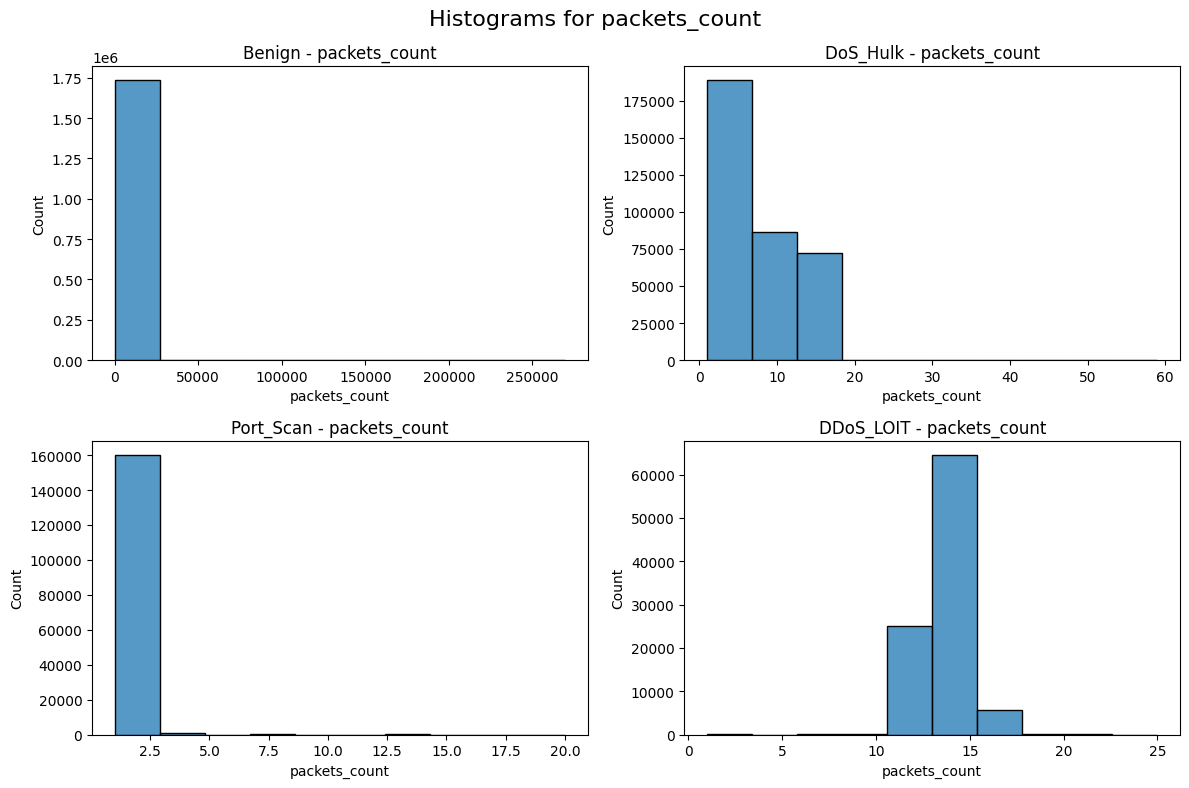

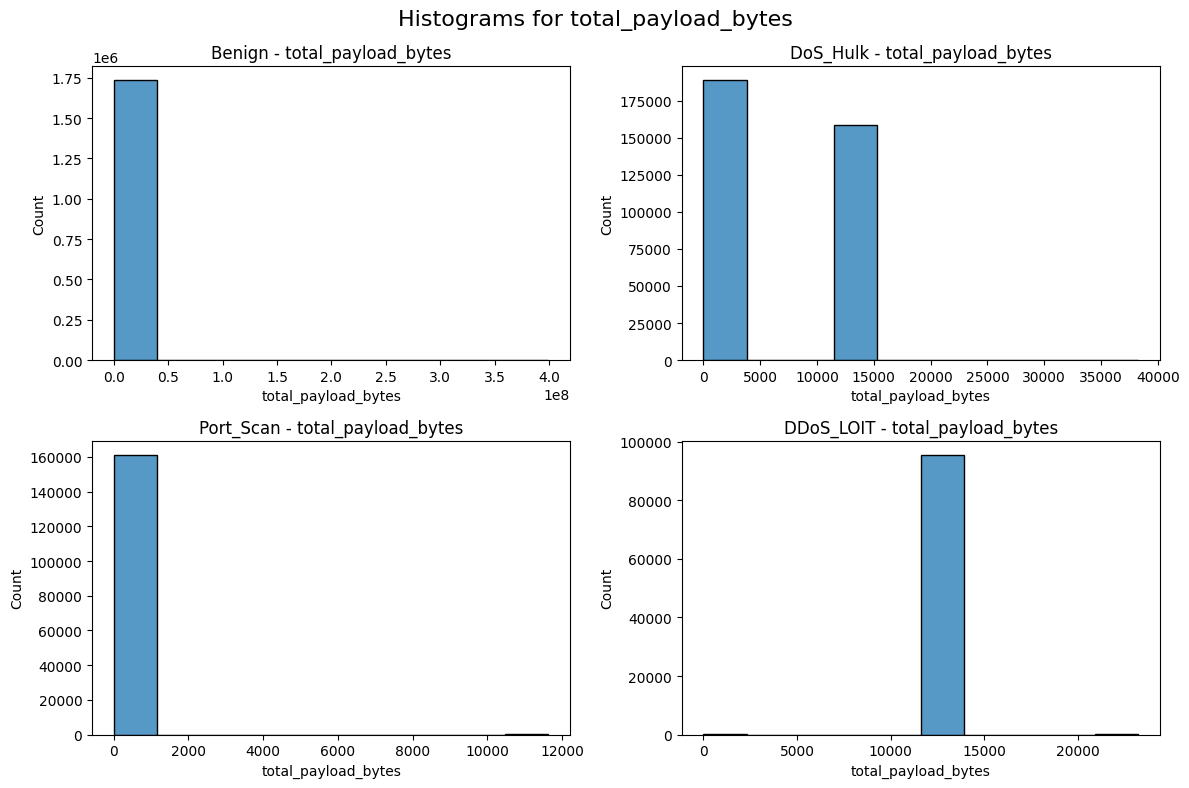

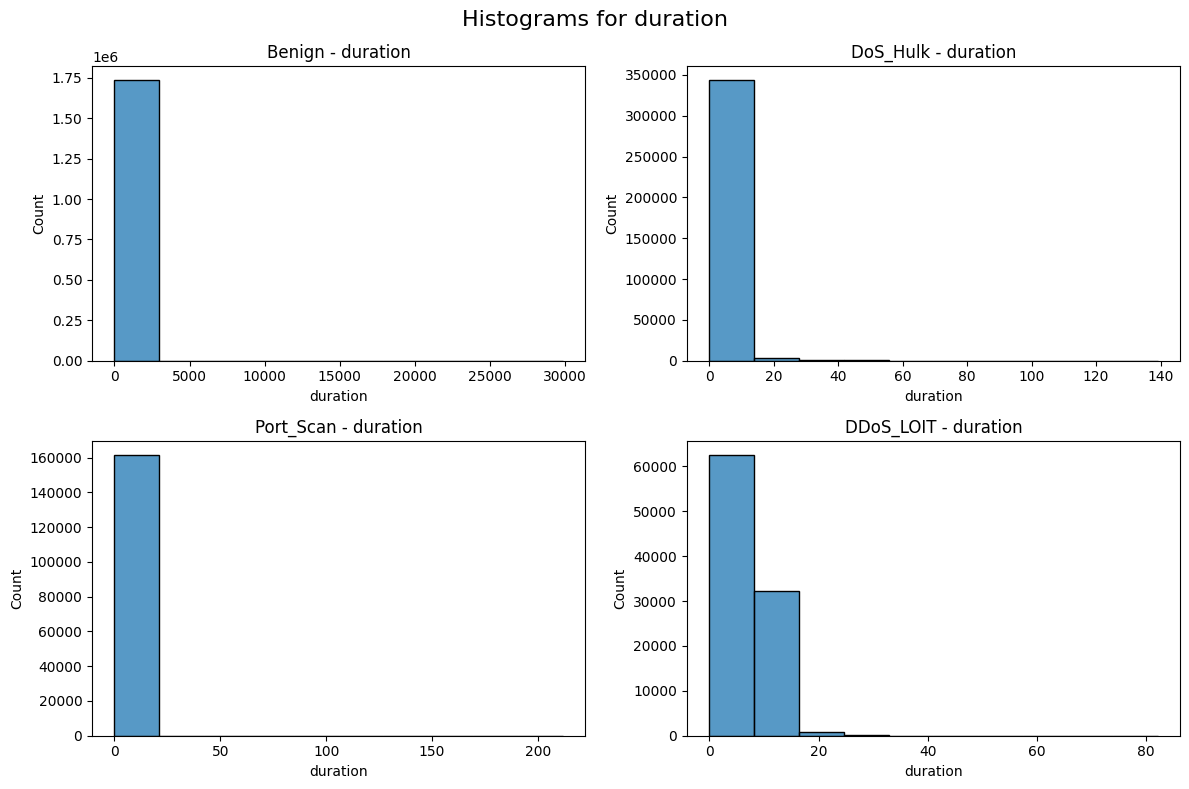

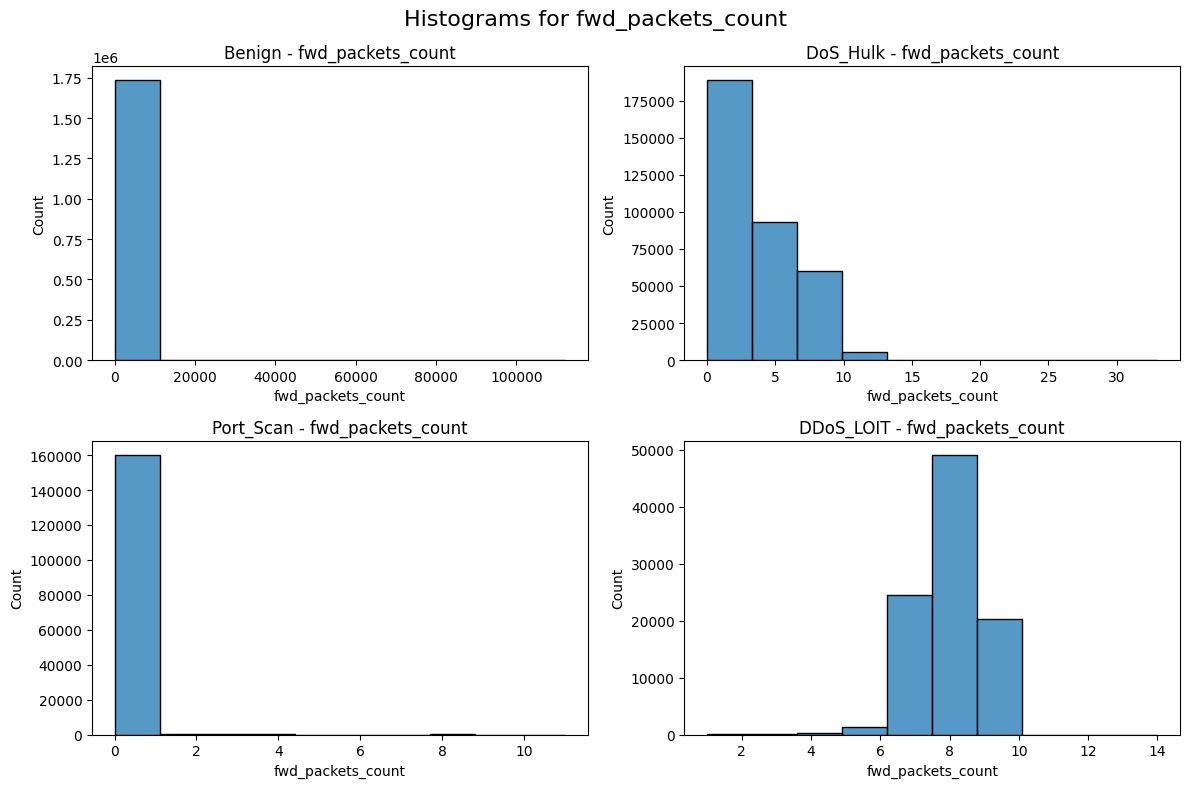

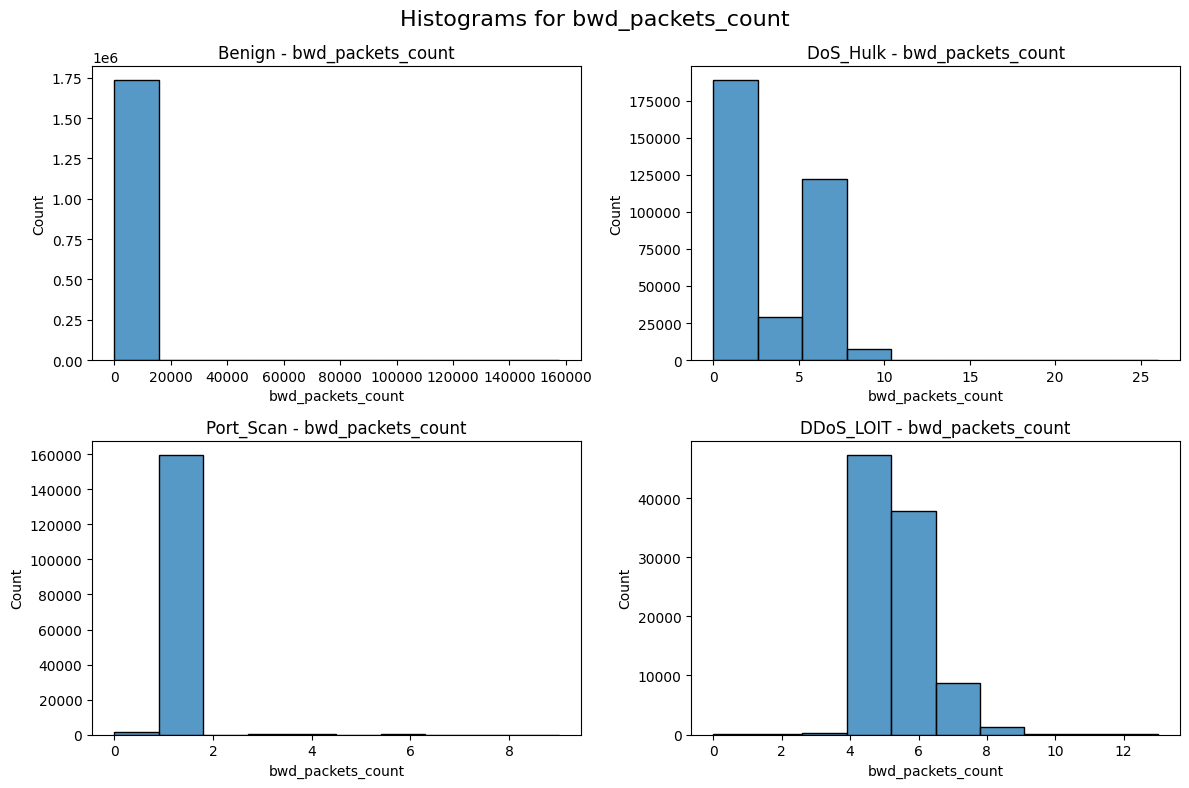

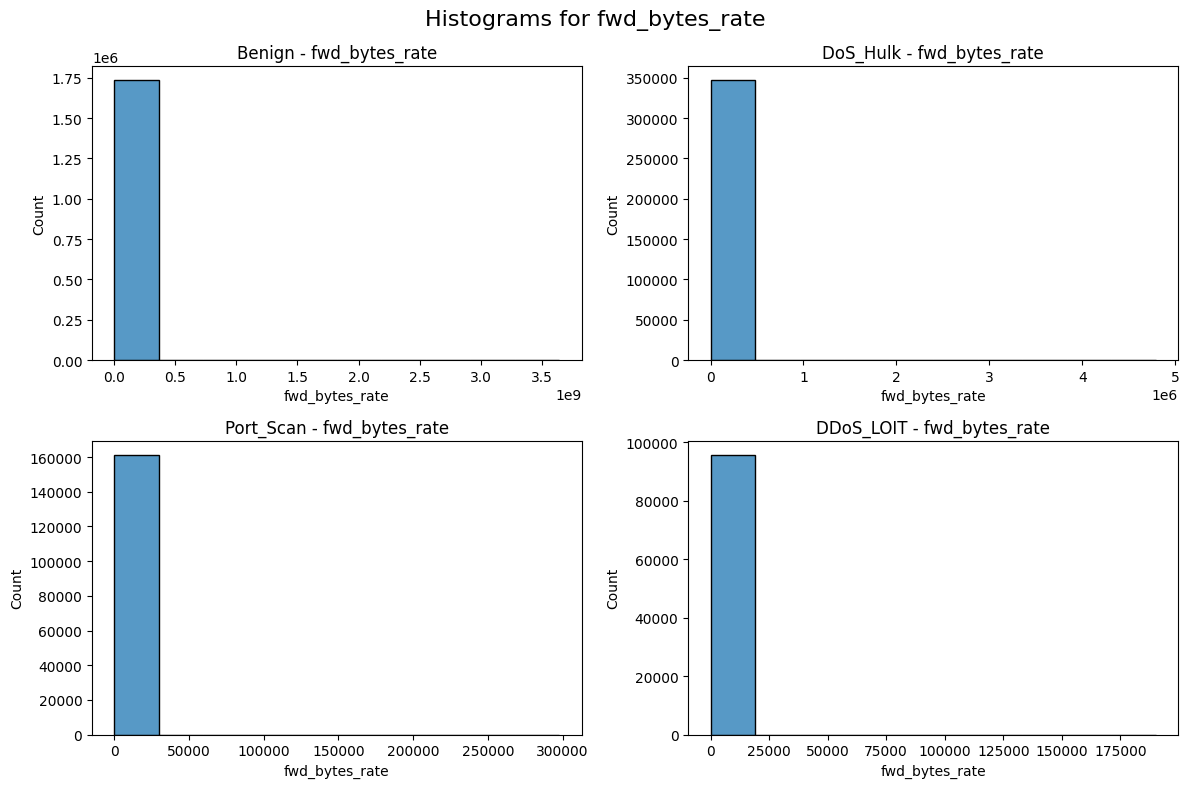

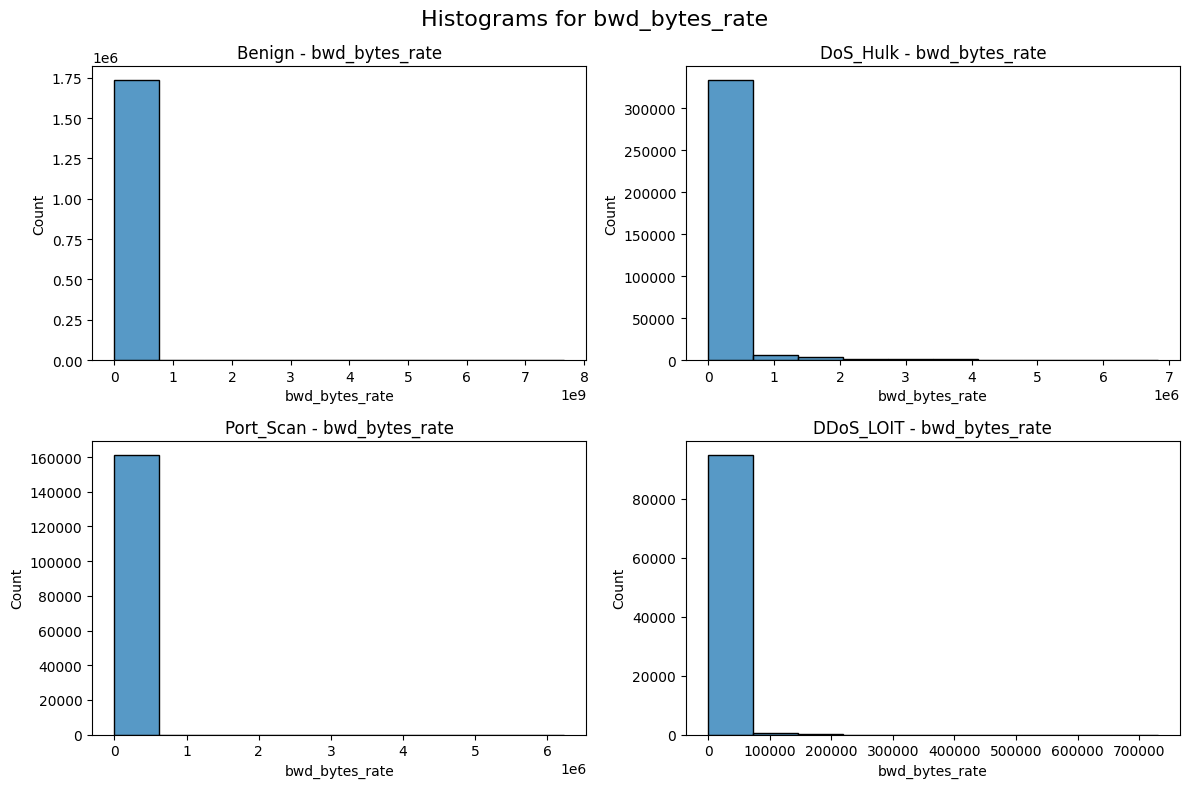

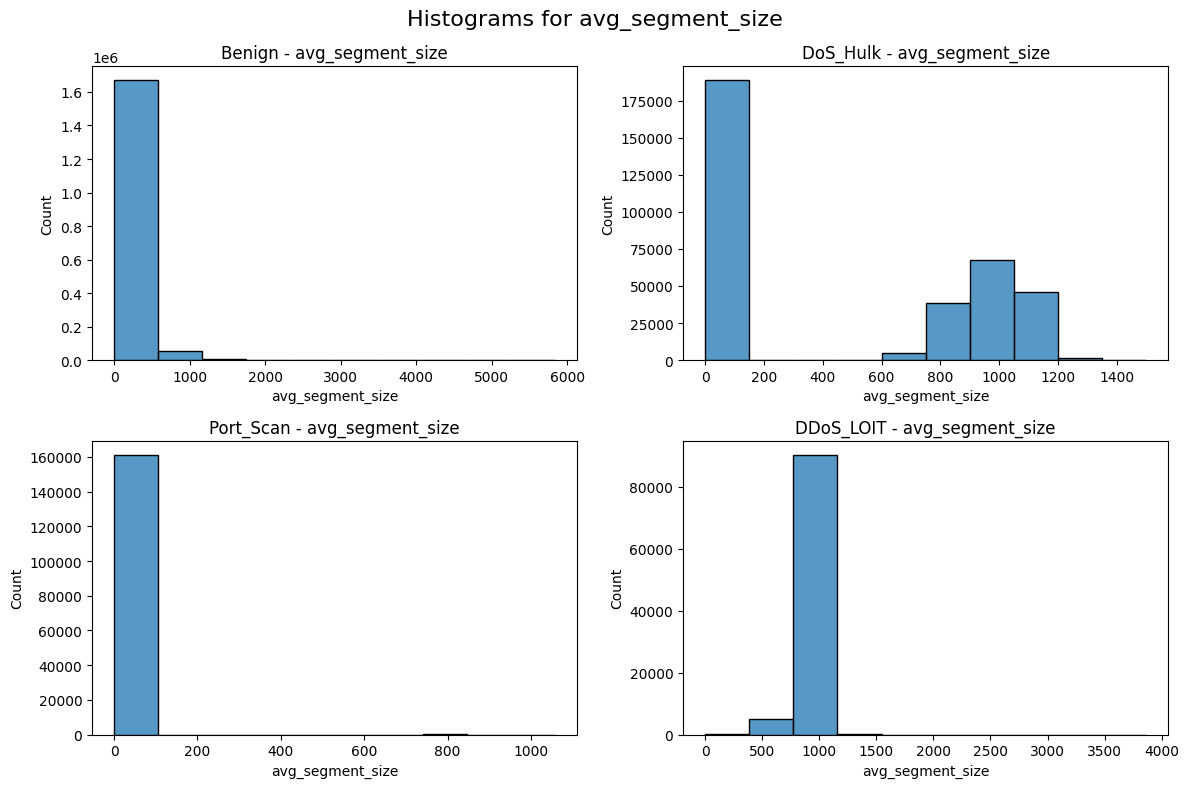

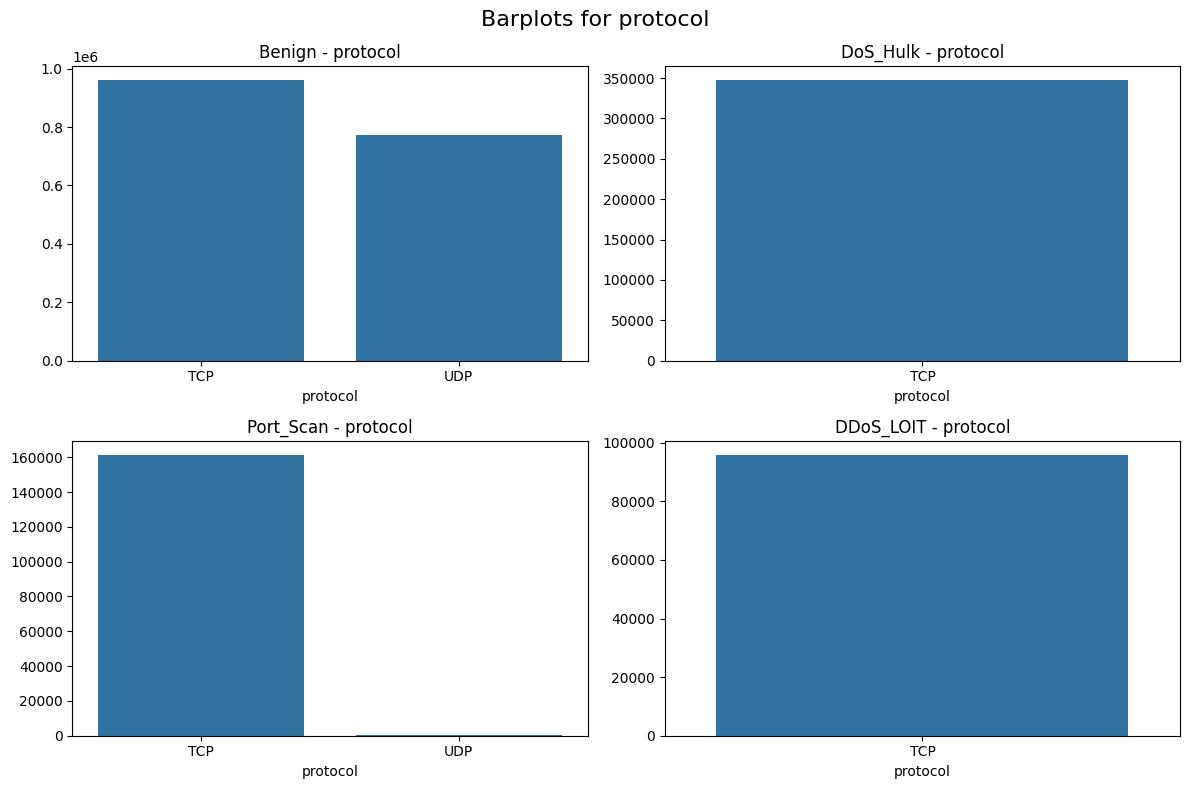

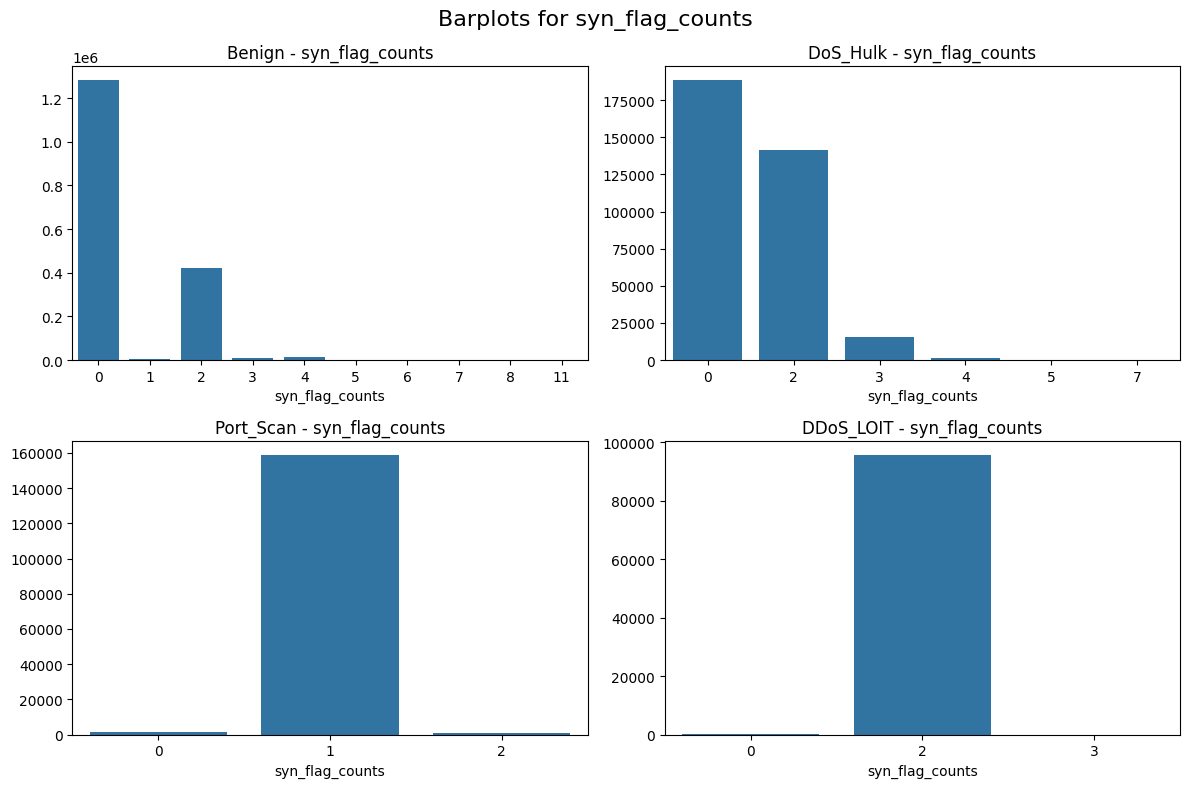

In [27]:
important_features = {
    'packets_count': 'histplot',
    'total_payload_bytes': 'histplot',
    'duration': 'histplot',
    'fwd_packets_count': 'histplot',
    'bwd_packets_count': 'histplot',
    'fwd_bytes_rate': 'histplot',
    'bwd_bytes_rate': 'histplot',
    'avg_segment_size': 'histplot',
    'protocol': 'barplot',
    'syn_flag_counts': 'barplot'
}

hist_features = [feat for feat, plot in important_features.items() if plot == 'histplot']
bar_features = [feat for feat, plot in important_features.items() if plot == 'barplot']

for feature in hist_features:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    sns.histplot(df_benign[feature], bins=10, kde=False, ax=axes[0, 0])
    axes[0, 0].set_title(f'Benign - {feature}')

    sns.histplot(df_doshulk[feature], bins=10, kde=False, ax=axes[0, 1])
    axes[0, 1].set_title(f'DoS_Hulk - {feature}')

    sns.histplot(df_portscan[feature], bins=10, kde=False, ax=axes[1, 0])
    axes[1, 0].set_title(f'Port_Scan - {feature}')

    sns.histplot(df_ddos_loit[feature], bins=10, kde=False, ax=axes[1, 1])
    axes[1, 1].set_title(f'DDoS_LOIT - {feature}')

    fig.suptitle(f'Histograms for {feature}', fontsize=16)
    plt.tight_layout()
    plt.show()


for feature in bar_features:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    sns.barplot(x=df_benign[feature].value_counts().index[:10],
                y=df_benign[feature].value_counts().values[:10], ax=axes[0, 0])
    axes[0, 0].set_title(f'Benign - {feature}')

    sns.barplot(x=df_doshulk[feature].value_counts().index[:10],
                y=df_doshulk[feature].value_counts().values[:10], ax=axes[0, 1])
    axes[0, 1].set_title(f'DoS_Hulk - {feature}')

    sns.barplot(x=df_portscan[feature].value_counts().index[:10],
                y=df_portscan[feature].value_counts().values[:10], ax=axes[1, 0])
    axes[1, 0].set_title(f'Port_Scan - {feature}')

    sns.barplot(x=df_ddos_loit[feature].value_counts().index[:10],
                y=df_ddos_loit[feature].value_counts().values[:10], ax=axes[1, 1])
    axes[1, 1].set_title(f'DDoS_LOIT - {feature}')

    fig.suptitle(f'Barplots for {feature}', fontsize=16)
    plt.tight_layout()
    plt.show()


Using label encoder to enode the Labels so that I could find correlation between the label and features for eda.

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df2['label'] = le.fit_transform(df2['label'])

<ipython-input-33-601e15e18c7c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = le.fit_transform(df2['label'])


In [34]:
correlation_matrix = df2.select_dtypes(include=['number']).corr()

correlation_with_label = correlation_matrix['label'].drop('label')

correlation_df = correlation_with_label.reset_index()
correlation_df.columns = ['Feature', 'Correlation_with_Label']
correlation_df = correlation_df.sort_values(by='Correlation_with_Label', ascending=False)

In [36]:
correlation_df.reset_index(drop=True, inplace=True)
correlation_df.head(25)

,Feature,Correlation_with_Label
0,rst_flag_counts,0.679447
1,bwd_rst_flag_counts,0.568112
2,std_header_bytes,0.472132
3,fwd_min_header_bytes,0.399753
4,mean_header_bytes,0.386783
5,fwd_mean_header_bytes,0.386580
6,max_header_bytes,0.371145
7,fwd_syn_flag_counts,0.314187
8,fwd_rst_flag_counts,0.307362
9,fwd_max_header_bytes,0.291460


In [37]:
top_10_features = correlation_df.head(10)['Feature'].tolist()
top_10_features

['rst_flag_counts',
 'bwd_rst_flag_counts',
 'std_header_bytes',
 'fwd_min_header_bytes',
 'mean_header_bytes',
 'fwd_mean_header_bytes',
 'max_header_bytes',
 'fwd_syn_flag_counts',
 'fwd_rst_flag_counts',
 'fwd_max_header_bytes']

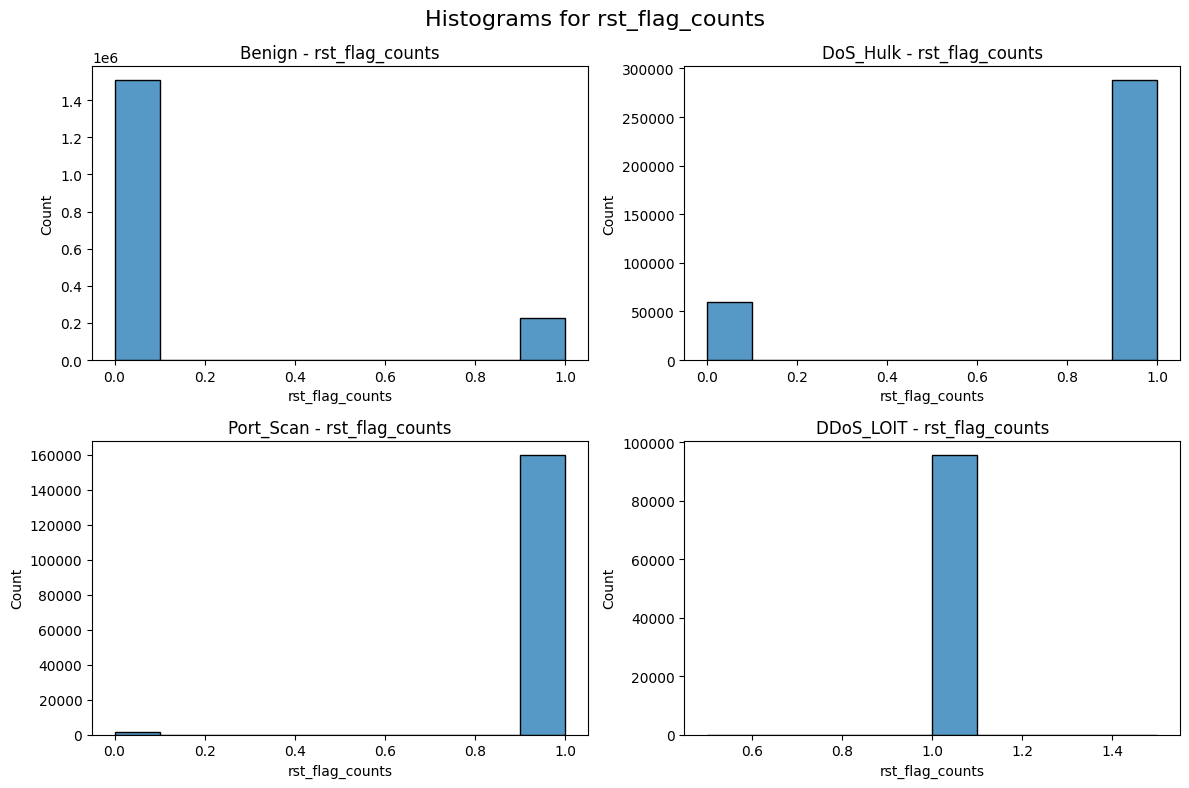

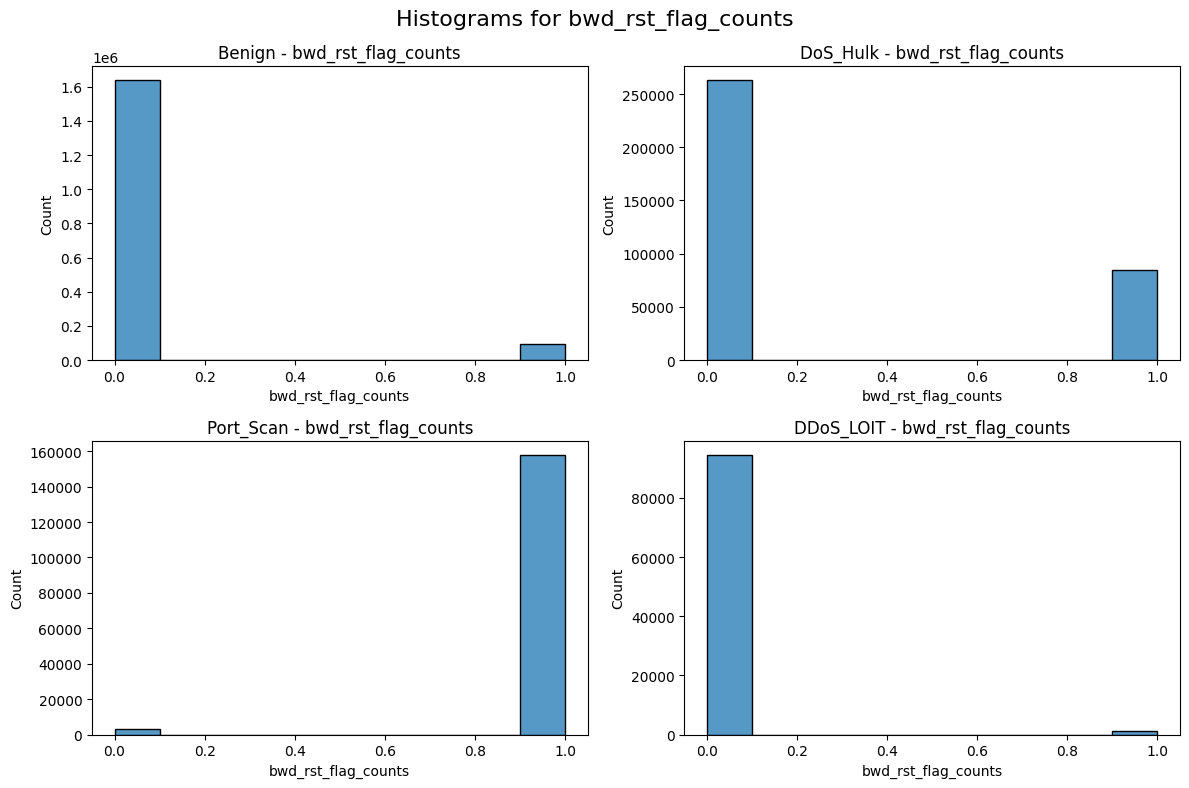

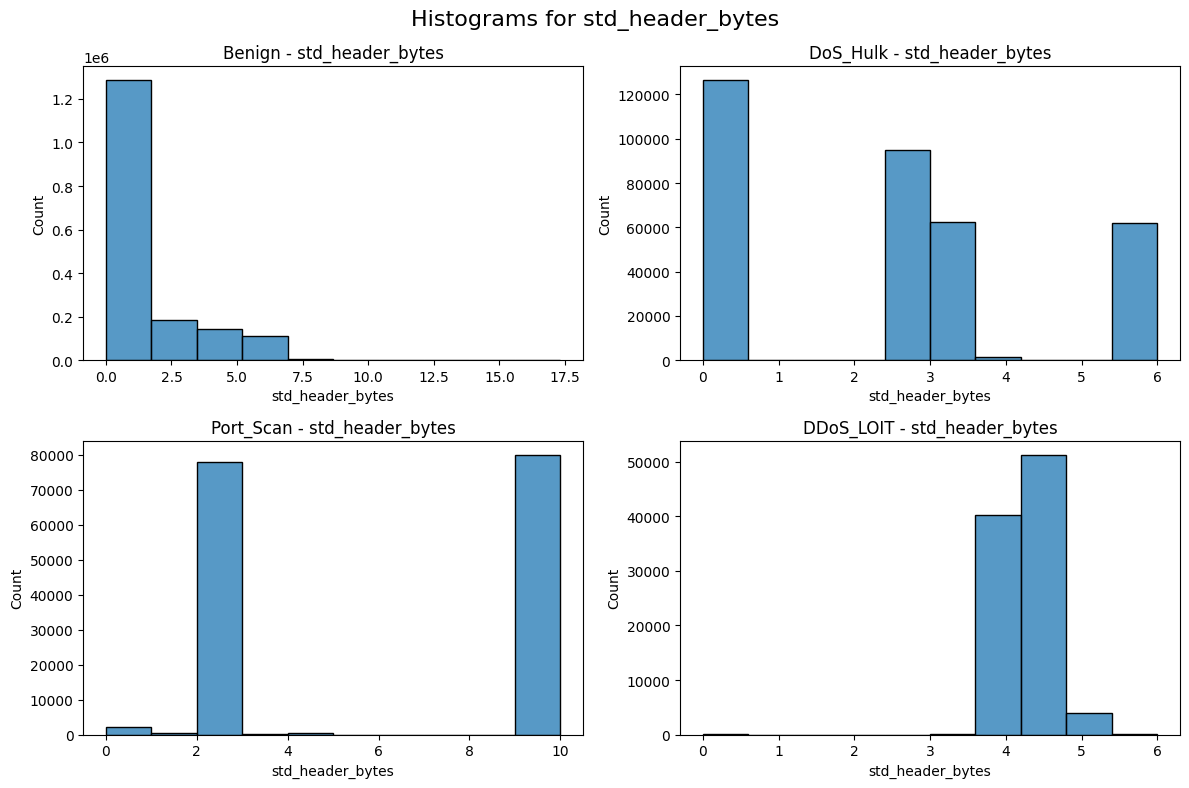

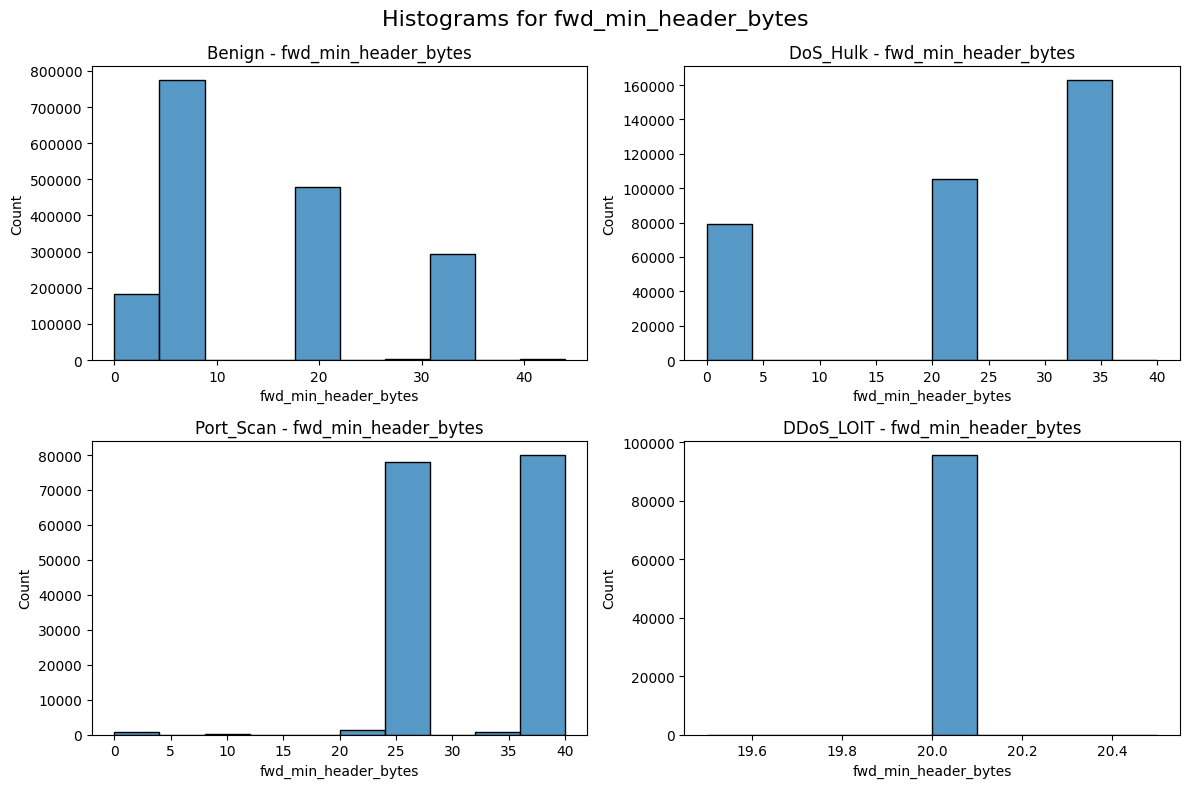

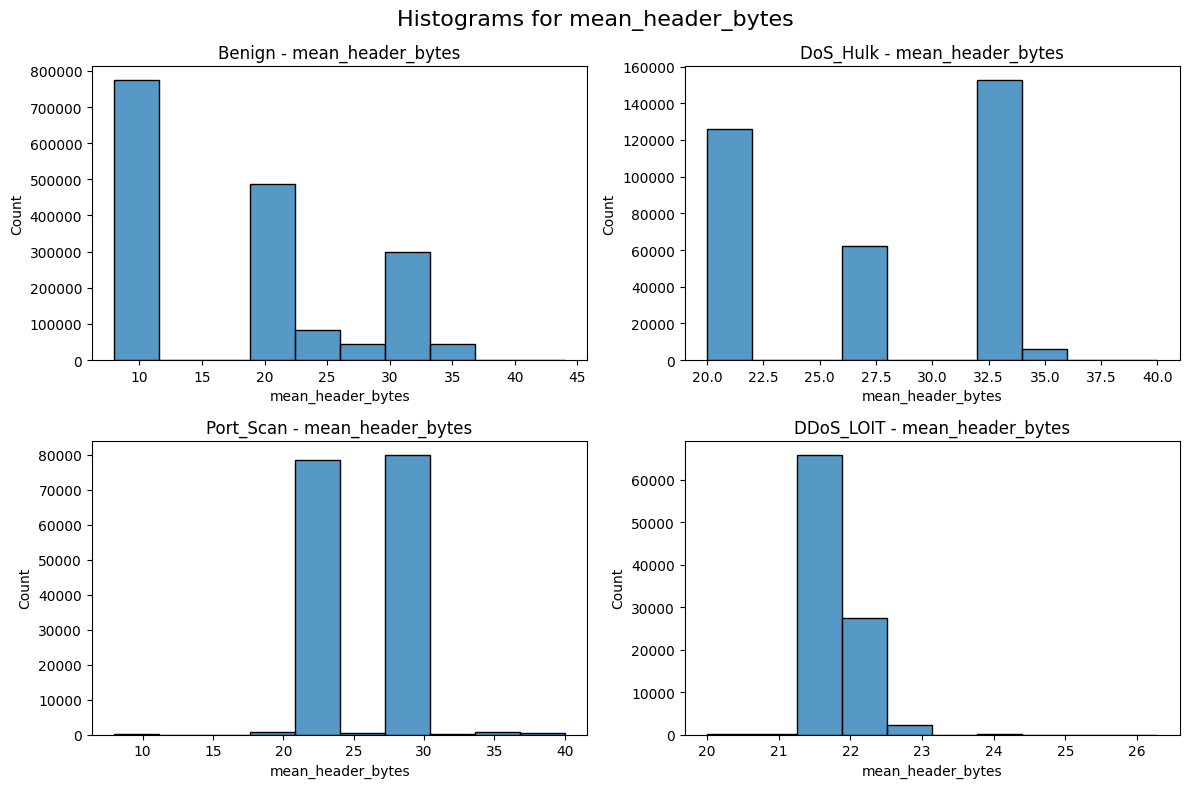

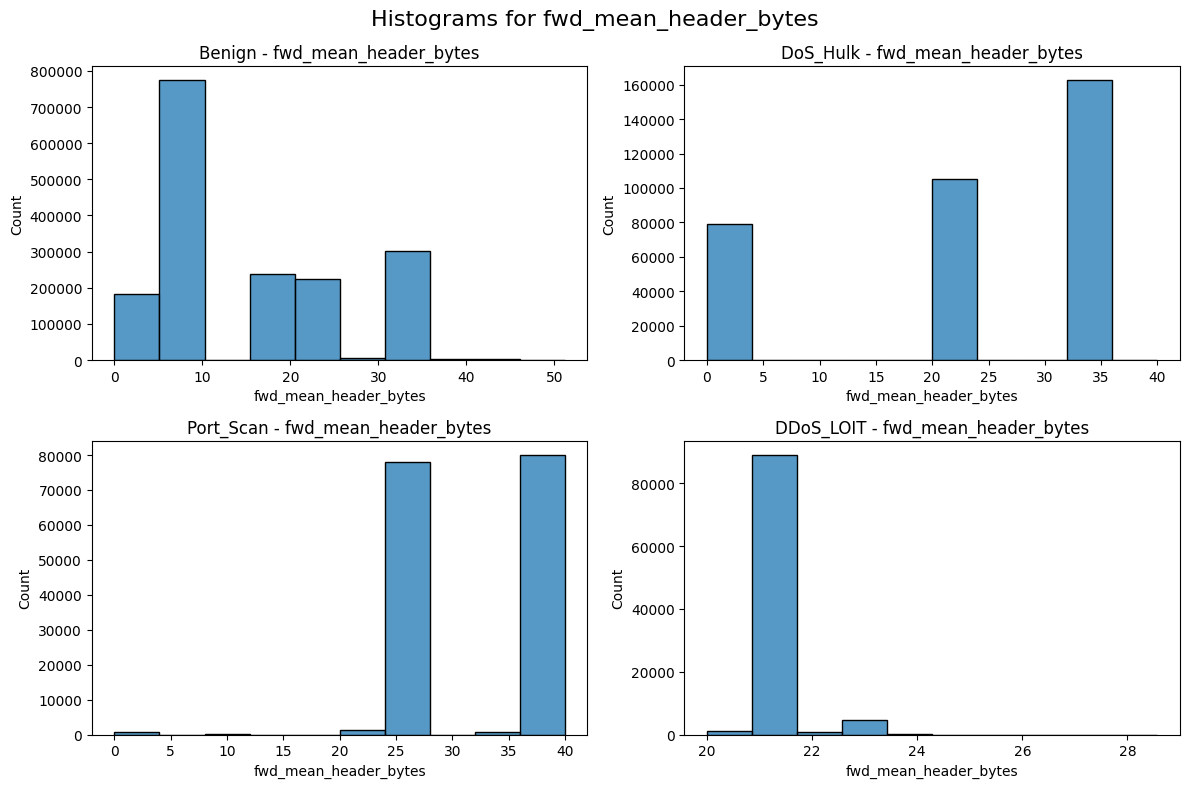

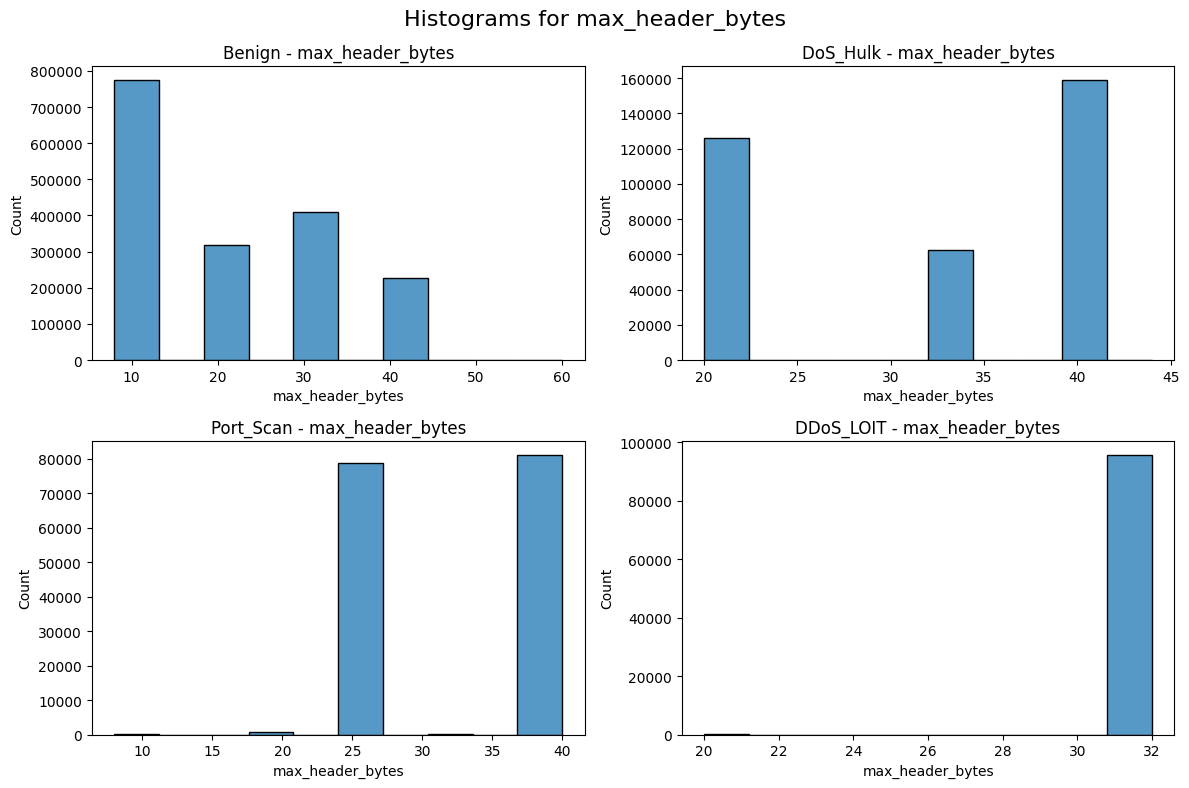

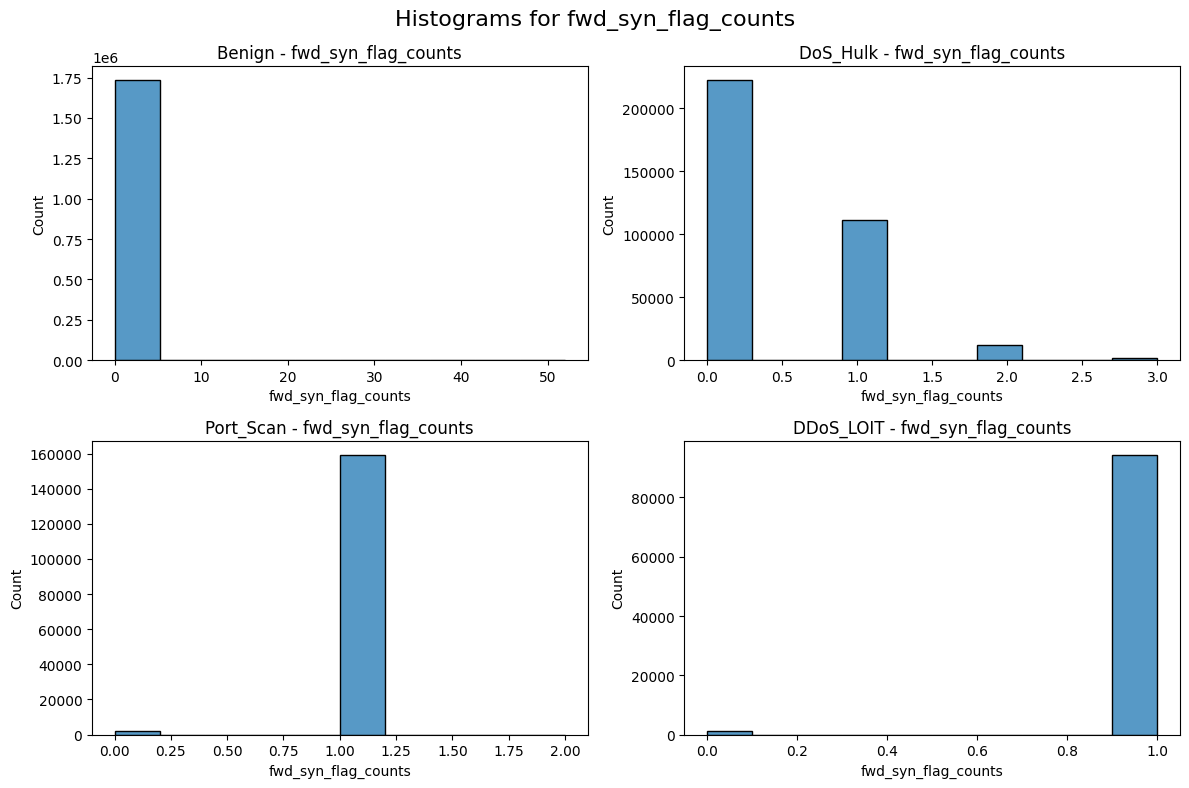

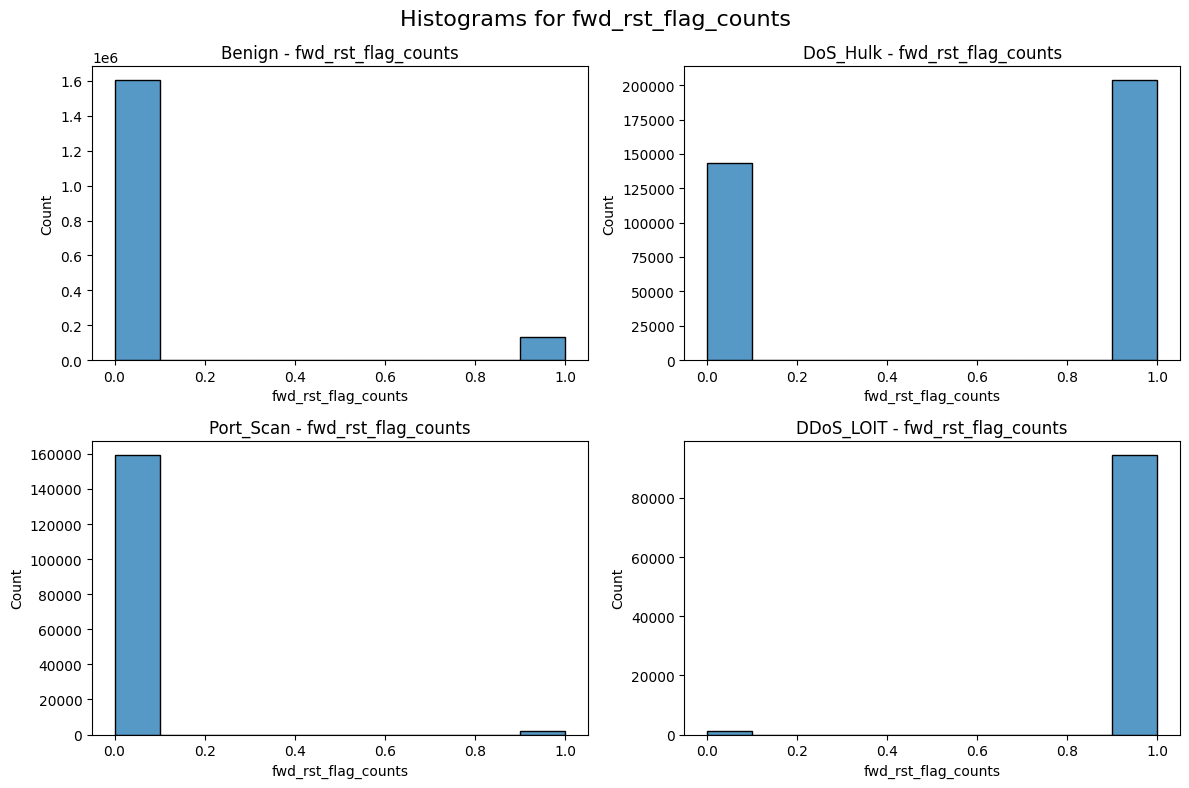

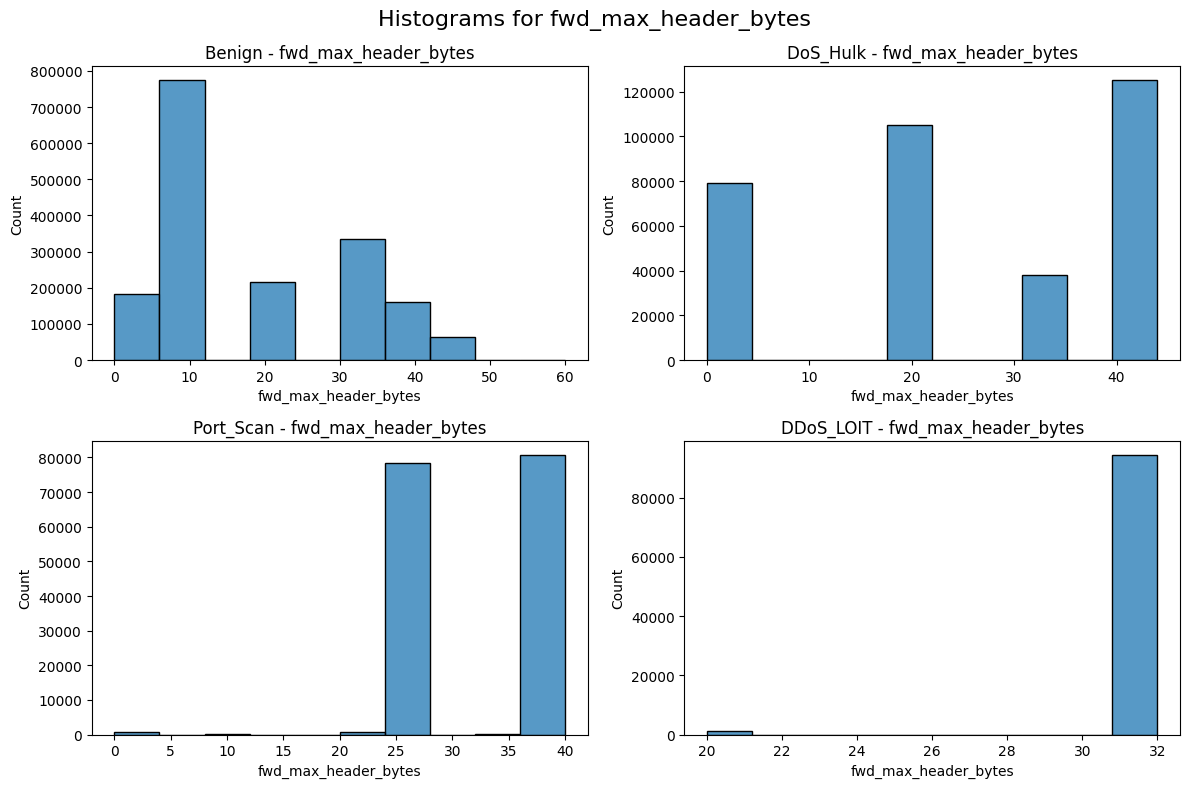

In [38]:
for feature in top_10_features:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    sns.histplot(df_benign[feature], bins=10, kde=False, ax=axes[0, 0])
    axes[0, 0].set_title(f'Benign - {feature}')

    sns.histplot(df_doshulk[feature], bins=10, kde=False, ax=axes[0, 1])
    axes[0, 1].set_title(f'DoS_Hulk - {feature}')

    sns.histplot(df_portscan[feature], bins=10, kde=False, ax=axes[1, 0])
    axes[1, 0].set_title(f'Port_Scan - {feature}')

    sns.histplot(df_ddos_loit[feature], bins=10, kde=False, ax=axes[1, 1])
    axes[1, 1].set_title(f'DDoS_LOIT - {feature}')

    fig.suptitle(f'Histograms for {feature}', fontsize=16)
    plt.tight_layout()
    plt.show()

I will investigate it further by taking the individual attacks and look at the correlations. But this is also promising as there are distictions with the feature names and the attacks.

Performed one-hot encoding to create dummy variables for categorical features.

In [74]:
df = pd.get_dummies(df, columns=['protocol'])

KeyError: "None of [Index(['protocol'], dtype='object')] are in the [columns]"

In [75]:
def split_ip(ip):
    return [int(octet) for octet in ip.split('.')]

df[['src_ip_1', 'src_ip_2', 'src_ip_3', 'src_ip_4']] = df['src_ip'].apply(split_ip).to_list()
df[['dst_ip_1', 'dst_ip_2', 'dst_ip_3', 'dst_ip_4']] = df['dst_ip'].apply(split_ip).to_list()

df = df.drop(['src_ip', 'dst_ip'], axis=1)

KeyError: 'src_ip'

The purpose of this code is to break down the src_ip (source IP address) and dst_ip (destination IP address) into their individual octets (separated by dots in the IP address format) and create new columns for each octet. This allows the IP addresses to be analyzed as separate numerical components.

![IP address](https://images.javatpoint.com/androidpages/images/ip-address-format-and-table.png)

The purpose of this code is to convert the timestamp column from its current format into a Unix timestamp format to make it compatible with machine learning models like XGBoost, which cannot directly handle datetime objects.

In [43]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
df['timestamp'] = df['timestamp'].astype(int) / 10**9

In [44]:
df.reset_index(drop=True, inplace=True)

In [53]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print("Label to encoded value mapping:")
print(label_mapping)

Label to encoded value mapping:
{'Benign': 0, 'DDoS_LOIT': 1, 'DoS_Hulk': 2, 'Port_Scan': 3}


In [97]:
df_benign = df[df['label'] == 0]
df_doshulk = df[df['label'] == 2]
df_portscan = df[df['label'] == 3]
df_ddos_loit = df[df['label'] == 1]

In [108]:
df1_benign_sample = df_benign.sample(n=150000, random_state=42)
df1_doshulk_sample = df_doshulk.sample(n=10000, random_state=42)

df1 = pd.concat([df1_benign_sample, df1_doshulk_sample], ignore_index=True)

In [109]:
df1['label'].value_counts()

,count
label,
0,150000
2,10000


In [110]:
df1.head()

,flow_id,timestamp,src_port,dst_port,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,payload_bytes_std,payload_bytes_variance,fwd_payload_bytes_max,fwd_payload_bytes_min,fwd_payload_bytes_mean,fwd_payload_bytes_std,fwd_payload_bytes_variance,bwd_payload_bytes_max,bwd_payload_bytes_min,bwd_payload_bytes_mean,bwd_payload_bytes_std,bwd_payload_bytes_variance,total_header_bytes,max_header_bytes,min_header_bytes,mean_header_bytes,std_header_bytes,fwd_total_header_bytes,fwd_max_header_bytes,fwd_min_header_bytes,fwd_mean_header_bytes,fwd_std_header_bytes,bwd_total_header_bytes,bwd_max_header_bytes,bwd_min_header_bytes,bwd_mean_header_bytes,bwd_std_header_bytes,fwd_avg_segment_size,bwd_avg_segment_size,avg_segment_size,fwd_init_win_bytes,bwd_init_win_bytes,active_min,active_max,active_mean,active_std,idle_min,idle_max,idle_mean,idle_std,bytes_rate,fwd_bytes_rate,bwd_bytes_rate,packets_rate,bwd_packets_rate,fwd_packets_rate,down_up_rate,avg_fwd_bytes_per_bulk,avg_fwd_packets_per_bulk,avg_fwd_bulk_rate,avg_bwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,avg_bwd_bulk_rate,fwd_bulk_state_count,fwd_bulk_total_size,fwd_bulk_per_packet,fwd_bulk_duration,bwd_bulk_state_count,bwd_bulk_total_size,bwd_bulk_per_packet,bwd_bulk_duration,fin_flag_counts,psh_flag_counts,urg_flag_counts,ece_flag_counts,syn_flag_counts,ack_flag_counts,cwr_flag_counts,rst_flag_counts,fwd_fin_flag_counts,fwd_psh_flag_counts,fwd_urg_flag_counts,fwd_ece_flag_counts,fwd_syn_flag_counts,fwd_ack_flag_counts,fwd_cwr_flag_counts,fwd_rst_flag_counts,bwd_fin_flag_counts,bwd_psh_flag_counts,bwd_urg_flag_counts,bwd_ece_flag_counts,bwd_syn_flag_counts,bwd_ack_flag_counts,bwd_cwr_flag_counts,bwd_rst_flag_counts,packets_IAT_mean,packet_IAT_std,packet_IAT_max,packet_IAT_min,packet_IAT_total,fwd_packets_IAT_mean,fwd_packets_IAT_std,fwd_packets_IAT_max,fwd_packets_IAT_min,fwd_packets_IAT_total,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes,label,target,protocol_TCP,protocol_UDP,src_ip_1,src_ip_2,src_ip_3,src_ip_4,dst_ip_1,dst_ip_2,dst_ip_3,dst_ip_4
0,192.168.10.3_61199_192.168.10.1_53_UDP_2017-07...,1.499088e+09,61199,53,0.000534,2,1,1,184,51,133,133,51,92.0,41.0,1681.00,133,51,92.0,41.0,0.0,133,51,92.0,41.0,0.0,16,8,8,8.0,0.0,8,8,8,8.0,0.0,8,8,8,8.0,0.0,51.0,133.0,92.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344532.114286,95495.314286,249036.800000,3744.914286,1872.457143,1872.457143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000534,0.000000,0.000534,0.000534,0.000534,1.499102e+09,0.0,1.499102e+09,1.499102e+09,1.499102e+09,1.499102e+09,0.0,1.499102e+09,1.499102e+09,1.499102e+09,0.0,0.0,0.0,0.0,0,False,False,True,192,168,10,3,192,168,10,1
1,192.168.10.8_52357_192.168.10.3_53_UDP_2017-07...,1.499166e+09,52357,53,0.350774,4,2,2,286,70,216,108,35,71.5,36.5,1332.25,108,35,71.5,36.5,0.0,108,35,71.5,36.5,0.0,32,8,8,8.0,0.0,16,8,8,8.0,0.0,16,8,8,8.0,0.0,35.0,108.0,71.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,815.339676,199.558662,615.781014,11.403352,5.701676,5.701676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.116925,0.165351,0.350767,0.000003,0.350774,3.100000e-06,0.0,3.099442e-06,3.099442e-06,3.099442e-06,4.050000e-06,0.0,4.053116e-06,4.053116e-06,4.053116e-06,0.0,0.0,0.0,0.0,0,False,False,True,192,168,10,8,192,168,10,3
2,192.168.10.16_53075_192.168.10.3_53_UDP_2017-0...,1.499172e+09,53075,53,0.050552,4,2,2,290,86,204,102,43,72.5,29.5,870.25,102,43,72.5,29.5,0.0,102,43,72.5,29.5,0.0,32,8,8,8.0,0.0,16,8,8,8.0,0.0,16,8,8,8.0,0.0,43.0,102.0,72.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5736.679526,1701.222204,4035.457322,79.126614,39.563307,39.563307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [111]:
X, y = df1.drop(['flow_id', 'label', 'target', 'timestamp', 'src_port', 'dst_port','src_ip_1',	'src_ip_2',	'src_ip_3',	'src_ip_4',	'dst_ip_1',	'dst_ip_2',	'dst_ip_3',	'dst_ip_4',], axis=1), df1['target']

In [112]:
X.head()

,duration,packets_count,fwd_packets_count,bwd_packets_count,total_payload_bytes,fwd_total_payload_bytes,bwd_total_payload_bytes,payload_bytes_max,payload_bytes_min,payload_bytes_mean,payload_bytes_std,payload_bytes_variance,fwd_payload_bytes_max,fwd_payload_bytes_min,fwd_payload_bytes_mean,fwd_payload_bytes_std,fwd_payload_bytes_variance,bwd_payload_bytes_max,bwd_payload_bytes_min,bwd_payload_bytes_mean,bwd_payload_bytes_std,bwd_payload_bytes_variance,total_header_bytes,max_header_bytes,min_header_bytes,mean_header_bytes,std_header_bytes,fwd_total_header_bytes,fwd_max_header_bytes,fwd_min_header_bytes,fwd_mean_header_bytes,fwd_std_header_bytes,bwd_total_header_bytes,bwd_max_header_bytes,bwd_min_header_bytes,bwd_mean_header_bytes,bwd_std_header_bytes,fwd_avg_segment_size,bwd_avg_segment_size,avg_segment_size,fwd_init_win_bytes,bwd_init_win_bytes,active_min,active_max,active_mean,active_std,idle_min,idle_max,idle_mean,idle_std,bytes_rate,fwd_bytes_rate,bwd_bytes_rate,packets_rate,bwd_packets_rate,fwd_packets_rate,down_up_rate,avg_fwd_bytes_per_bulk,avg_fwd_packets_per_bulk,avg_fwd_bulk_rate,avg_bwd_bytes_per_bulk,avg_bwd_packets_bulk_rate,avg_bwd_bulk_rate,fwd_bulk_state_count,fwd_bulk_total_size,fwd_bulk_per_packet,fwd_bulk_duration,bwd_bulk_state_count,bwd_bulk_total_size,bwd_bulk_per_packet,bwd_bulk_duration,fin_flag_counts,psh_flag_counts,urg_flag_counts,ece_flag_counts,syn_flag_counts,ack_flag_counts,cwr_flag_counts,rst_flag_counts,fwd_fin_flag_counts,fwd_psh_flag_counts,fwd_urg_flag_counts,fwd_ece_flag_counts,fwd_syn_flag_counts,fwd_ack_flag_counts,fwd_cwr_flag_counts,fwd_rst_flag_counts,bwd_fin_flag_counts,bwd_psh_flag_counts,bwd_urg_flag_counts,bwd_ece_flag_counts,bwd_syn_flag_counts,bwd_ack_flag_counts,bwd_cwr_flag_counts,bwd_rst_flag_counts,packets_IAT_mean,packet_IAT_std,packet_IAT_max,packet_IAT_min,packet_IAT_total,fwd_packets_IAT_mean,fwd_packets_IAT_std,fwd_packets_IAT_max,fwd_packets_IAT_min,fwd_packets_IAT_total,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes,protocol_TCP,protocol_UDP
0,0.000534,2,1,1,184,51,133,133,51,92.0,41.0,1681.00,133,51,92.0,41.0,0.0,133,51,92.0,41.0,0.0,16,8,8,8.0,0.0,8,8,8,8.0,0.0,8,8,8,8.0,0.0,51.0,133.0,92.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344532.114286,95495.314286,249036.800000,3744.914286,1872.457143,1872.457143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000534,0.000000,0.000534,0.000534,0.000534,1.499102e+09,0.0,1.499102e+09,1.499102e+09,1.499102e+09,1.499102e+09,0.0,1.499102e+09,1.499102e+09,1.499102e+09,0.0,0.0,0.0,0.0,False,True
1,0.350774,4,2,2,286,70,216,108,35,71.5,36.5,1332.25,108,35,71.5,36.5,0.0,108,35,71.5,36.5,0.0,32,8,8,8.0,0.0,16,8,8,8.0,0.0,16,8,8,8.0,0.0,35.0,108.0,71.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,815.339676,199.558662,615.781014,11.403352,5.701676,5.701676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.116925,0.165351,0.350767,0.000003,0.350774,3.100000e-06,0.0,3.099442e-06,3.099442e-06,3.099442e-06,4.050000e-06,0.0,4.053116e-06,4.053116e-06,4.053116e-06,0.0,0.0,0.0,0.0,False,True
2,0.050552,4,2,2,290,86,204,102,43,72.5,29.5,870.25,102,43,72.5,29.5,0.0,102,43,72.5,29.5,0.0,32,8,8,8.0,0.0,16,8,8,8.0,0.0,16,8,8,8.0,0.0,43.0,102.0,72.5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5736.679526,1701.222204,4035.457322,79.126614,39.563307,39.563307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.016851,0.023826,0.050546,0.000003,0.050552,2.860000e-06,0.0,2.861023e-06,2.861023e-06,2.861023e-06,2.860000e-06,0.0,2.861023e-06,2.861023e-06,2.861023e-06,0.0,0.0,0.0,0.0,False,True
3,0.047442,4,2,2,252,78,174,87,39,63.0,24.0,576.00,87,39,63.0,24.0,0.0,87,39,63.0,24.0,0.0,32,8,8,8.0,0.0,16,8,8,8.0,0.0,16,8,8,8.0,0.0,39.0,87.0,63.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5311.753631,1644.114219,3667.6

In [113]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Columns: 116 entries, duration to protocol_UDP
dtypes: bool(2), float32(31), float64(30), int16(10), int32(16), int64(3), int8(24)
memory usage: 76.0 MB


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
model = XGBClassifier(enable_categorical=True)

In [116]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [117]:
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

precision = precision_score(y_test, predictions, pos_label=1)
recall = recall_score(y_test, predictions, pos_label=1)
f1 = f1_score(y_test, predictions, pos_label=1)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

target_names = ["Class 0", "Class 1"]
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=target_names))

Accuracy: 0.99996875

Precision: 1.0
Recall: 0.9994962216624685
F1-Score: 0.999748047367095

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     30015
     Class 1       1.00      1.00      1.00      1985

    accuracy                           1.00     32000
   macro avg       1.00      1.00      1.00     32000
weighted avg       1.00      1.00      1.00     32000

